In [1]:
import os
import sys
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "../../../src")
from config.data_config import HEADER_MAPPING
# from visualization.plotting_functions.boxplot import plot_monthly_boxplots

In [120]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_grouped_boxplots(data, title):
    """
    Plot grouped boxplots for preprocessed data.

    Args:
        data (pd.DataFrame): Preprocessed data containing columns 'value', 'source', 'parameter', and 'month'.
        output_filepath (str): Path to save the output plot.
    """

    # Extract unique parameters and sources
    parameters = data["parameter"].unique()
    print("parameters: ", parameters)
    sources = data["source"].unique()
    print("sources: ", sources)
    colors = ["skyblue", "red", "lightgreen", "orange"]

    for parameter in parameters:
        fig, ax = plt.subplots(figsize=(20, 4))

        legends = []
        source_data_list = []
        positions_dict = {}

        for idx, source in enumerate(sources):
            source_data = data[
                (data["parameter"] == parameter) & (data["source"] == source)
            ]
            print("source data: ", source_data)
            source_data_grouped = source_data.groupby("month")["value"].apply(list)
            print("source data grouped: ", source_data_grouped)
            months = source_data_grouped.index.astype(str)
            pos = list(range(len(months)))
            pos = [p + 0.6 * idx for p in pos]
            
            for month, position in zip(months, pos):
                if month not in positions_dict:
                    positions_dict[month] = []
                positions_dict[month].append(position)
                
            # if len(source_data_grouped) == len(pos):
            bp = ax.boxplot(
                source_data_grouped,
                positions=pos,
                widths=0.5,
                patch_artist=True,
                boxprops=dict(facecolor=colors[idx % len(colors)]),
                showfliers=False,
                showmeans=True,
            )
            legends.append(bp["boxes"][0])
            source_data_list.append(source_data_grouped)
            # else:
            #     print(
            #         f"Skipping {source} for parameter {parameter} due to mismatch in lengths"
            #     )
            #     print(f"source_data_grouped: {source_data_grouped}")
            #     print(f"positions: {pos}")

        # Calculate middle positions for x-ticks
        middle_positions = [
            sum(positions) / len(positions) for positions in positions_dict.values()
        ]
        plt.xticks(ticks=middle_positions, labels=months, rotation=90, ha="center")
        # Customize plot
        plt.title(f"Monthly Boxplot for {parameter} at {title}")
        plt.suptitle("")
        plt.xlabel("Month")
        plt.ylabel("Value")
        # plt.xticks(ticks=list(range(len(months))), labels=months, rotation=90)
        plt.legend(legends, sources, title="Source")
        plt.tight_layout()
        plt.show()


In [2]:
def load_colocation_data(metadata_file):
    with open(metadata_file, "r") as f:
        metadata = json.load(f)
    return metadata


# def load_site_data(
#     location, sensor_id, start_date, end_date, freq, aqms_filepath, pas_filepath
# ):
#     aqms_data = pd.read_csv(
#         aqms_filepath, parse_dates=["datetime_utc"], index_col="datetime_utc"
#     )
#     pas_data = pd.read_csv(
#         pas_filepath, parse_dates=["datetime_utc"], index_col="datetime_utc"
#     )
#     return aqms_data, pas_data

def load_site_data(aqms_filepath, pas_filepaths):
    """
    Load AQMS and PAS data from the specified file paths.

    Args:
        aqms_filepath (str): Path to the AQMS data file.
        pas_filepaths (dict): Dictionary of PAS file paths with sensor IDs as keys.

    Returns:
        pd.DataFrame, dict: AQMS data and dictionary of PAS data.
    """
    # Load AQMS data
    aqms_data = pd.read_csv(aqms_filepath, index_col=0, parse_dates=True)

    # Load PAS data into a dictionary
    pas_data = {}
    for sensor_id, filepath in pas_filepaths.items():
        pas_data[sensor_id] = pd.read_csv(filepath, index_col=0, parse_dates=True)

    return aqms_data, pas_data

def prepare_data_for_plotting(aqms_data, pas_data, header_mapping):
    # Initialize the source column
    aqms_data["source"] = "AQMS"
    print(aqms_data)
    pas_data["source"] = "PAS"
    print(pas_data)
    combined_data = pd.DataFrame()

    for aqms_col, pas_col in header_mapping.items():
        if isinstance(pas_col, list):
            for col in pas_col:
                if col in pas_data.columns:
                    temp_df = pas_data[[col, "source"]].copy()
                    temp_df.columns = [aqms_col, "source"]
                    combined_data = pd.concat([combined_data, temp_df])
        else:
            if pas_col in pas_data.columns:
                temp_df = pas_data[[pas_col, "source"]].copy()
                temp_df.columns = [aqms_col, "source"]
                combined_data = pd.concat([combined_data, temp_df])
    print("combined data pas: ", combined_data)
    aqms_subset = aqms_data[list(header_mapping.keys()) + ["source"]]
    print("aqms subset: ", aqms_subset)
    combined_data = pd.concat([combined_data, aqms_subset])
    print("combined data before melt: ", combined_data)
    combined_data.index = pd.to_datetime(combined_data.index, utc=True)

    combined_data = combined_data.melt(
        id_vars=["source"],
        var_name="parameter",
        value_name="value",
        ignore_index=False,
    )

    combined_data["month"] = combined_data.index.to_period("M")
    print("combined_data: ", combined_data)
    return combined_data

In [146]:
def load_and_prepare_all_sites(metadata_file, header_mapping, freq):
    metadata = load_colocation_data(metadata_file)

    all_sites_data = pd.DataFrame()

    for location, details in metadata.items():
        aqms_details = details.get("AQMS", {})
        site_id = details["AQMS"]["site_id"]
        aqms_start_date, aqms_end_date = aqms_details["data_range"]

        sensors = details.get("PAS", {})
        for sensor_id, sensor_details in sensors.items():
            sensor_start_date, sensor_end_date = sensor_details["data_range"]

            start_date = max(aqms_start_date, sensor_start_date)
            end_date = min(aqms_end_date, sensor_end_date)

            start_date_formatted = start_date.replace("-", "")
            end_date_formatted = end_date.replace("-", "")
            aqms_filepath = f"../../../data/raw/colocation/{location}/AQMS/{start_date_formatted}_{end_date_formatted}/aqms_{site_id}_{start_date_formatted}_{end_date_formatted}_{freq}.csv"
            pas_filepath = f"../../../data/processed/colocation/{location}/PAS/{sensor_id}/{start_date_formatted}_{end_date_formatted}/pas_{sensor_id}_{start_date_formatted}_{end_date_formatted}_{freq}.csv"
            aqms_data, pas_data = load_site_data(
                location,
                sensor_id,
                start_date,
                end_date,
                freq,
                aqms_filepath,
                pas_filepath,
            )
            site_data = prepare_data_for_plotting(aqms_data, pas_data, header_mapping)
            site_data["site"] = location
            print("Site: ", site_data)
            plot_grouped_boxplots(site_data, title=location)
            all_sites_data = pd.concat([all_sites_data, site_data])
    return all_sites_data


# Load and prepare data for all sites
metadata_file = "../../../metadata/colocation/colocation.json"
all_sites_data = load_and_prepare_all_sites(metadata_file, HEADER_MAPPING, "daily")
print(all_sites_data)

combined_data:                            source parameter      value    month
datetime_utc                                                  
2019-04-02 00:00:00+00:00    PAS     HUMID  24.492000  2019-04
2019-04-04 00:00:00+00:00    PAS     HUMID  26.853000  2019-04
2019-05-10 00:00:00+00:00    PAS     HUMID  28.886000  2019-05
2019-05-11 00:00:00+00:00    PAS     HUMID  28.156000  2019-05
2019-05-12 00:00:00+00:00    PAS     HUMID  29.686000  2019-05
...                          ...       ...        ...      ...
2024-05-26 00:00:00+00:00   AQMS      PM10  12.773455  2024-05
2024-05-27 00:00:00+00:00   AQMS      PM10  17.491625  2024-05
2024-05-28 00:00:00+00:00   AQMS      PM10  18.759417  2024-05
2024-05-29 00:00:00+00:00   AQMS      PM10  24.609652  2024-05
2024-05-30 00:00:00+00:00   AQMS      PM10   4.257357  2024-05

[36860 rows x 4 columns]
Site:                            source parameter      value    month      site
datetime_utc                                               

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_14688\2955765078.py:51: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


TypeError: plot_grouped_boxplots() got an unexpected keyword argument 'title'

In [ ]:
def plot_monthly_boxplots(all_sites_data):
    parameters = all_sites_data["parameter"].unique()
    sites = all_sites_data["site"].unique()

    for parameter in parameters:
        plt.figure(figsize=(12, 6))
        colors = ["skyblue", "lightgreen", "lightcoral"]
        legends = []
        site_sources = []

        for site in sites:
            site_data = all_sites_data[
                (all_sites_data["parameter"] == parameter)
                & (all_sites_data["site"] == site)
            ]
            site_sources = site_data["source"].unique()
            print("site sources: ", site_sources)
            for idx, source in enumerate(site_sources):
                source_data = site_data[site_data["source"] == source]
                print('source data: ', source_data)
                source_data_grouped = source_data.groupby("month")["value"].apply(list)

                months = source_data_grouped.index.astype(str)
                positions = list(range(len(months)))
                positions = [p + 0.1 * idx for p in positions]
                print("source: ", len(source_data_grouped))
                print("pos: ", len(positions))
                print("source: ", source_data_grouped)
                print("pos: ", positions)
                
                if len(source_data_grouped) == len(positions):
                    bp = plt.boxplot(
                        source_data_grouped,
                        positions=positions,
                        widths=0.1,
                        patch_artist=True,
                        boxprops=dict(facecolor=colors[idx % len(colors)]),
                        showfliers=False,
                        showmeans=True,
                    )
                    legends.append(bp["boxes"][0])
                else:
                    print(
                        f"Skipping {site}-{source} for parameter {parameter} due to mismatch in lengths"
                    )
                    print(f"source_data_grouped: {source_data_grouped}")
                    print(f"positions: {positions}")
                print(f"{parameter}, {site}")
        plt.title(f"Monthly Boxplot for {parameter}")
        plt.suptitle("")
        plt.xlabel("Month")
        plt.ylabel("Value")
        plt.xticks(ticks=list(range(len(months))), labels=months, rotation=90)
        plt.legend(legends, site_sources, title="Source")
        plt.tight_layout()
        plt.show()

In [54]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_grouped_boxplots(data):
    """
    Plot grouped boxplots for preprocessed data.

    Args:
        data (pd.DataFrame): Preprocessed data containing columns 'value', 'source', 'parameter', and 'month'.
        output_filepath (str): Path to save the output plot.
    """

    # Extract unique parameters and sources
    parameters = data["parameter"].unique()
    sources = data["source"].unique()
    colors = ["skyblue", "lightgreen", "orange"]

    for parameter in parameters:
        plt.figure(figsize=(12, 6))
        legends = []
        source_data_list = []
        positions_dict = {}

        for idx, source in enumerate(sources):
            source_data = data[
                (data["parameter"] == parameter) & (data["source"] == source)
            ]
            source_data_grouped = source_data.groupby("month")["value"].apply(list)

            months = source_data_grouped.index.astype(str)
            pos = list(range(len(months)))
            pos = [p + 0.1 * idx for p in pos]
            
            for month, position in zip(months, pos):
                if month not in positions_dict:
                    positions_dict[month] = []
                positions_dict[month].append(position)
                
            if len(source_data_grouped) == len(pos):
                bp = plt.boxplot(
                    source_data_grouped,
                    positions=pos,
                    widths=0.1,
                    patch_artist=True,
                    boxprops=dict(facecolor=colors[idx % len(colors)]),
                    showfliers=False,
                    showmeans=True,
                )
                legends.append(bp["boxes"][0])
                source_data_list.append(source_data_grouped)
            else:
                print(
                    f"Skipping {source} for parameter {parameter} due to mismatch in lengths"
                )
                print(f"source_data_grouped: {source_data_grouped}")
                print(f"positions: {pos}")

        # Calculate middle positions for x-ticks
        middle_positions = [
            sum(positions) / len(positions) for positions in positions_dict.values()
        ]
        plt.xticks(ticks=middle_positions, labels=months, rotation=90, ha="center")
        # Customize plot
        plt.title(f"Monthly Boxplot for {parameter}")
        plt.suptitle("")
        plt.xlabel("Month")
        plt.ylabel("Value")
        # plt.xticks(ticks=list(range(len(months))), labels=months, rotation=90)
        plt.legend(legends, sources, title="Source")
        plt.tight_layout()
        plt.show()


# Example usage:
# output_filepath = "path/to/output_dir"
# Assume 'preprocessed_data' is the data already prepared for plotting
# plot_grouped_boxplots(preprocessed_data, output_filepath)

In [ ]:
import pandas as pd
import numpy as np

# Define the example data
data = {
    "value": np.random.rand(300),
    "source": np.random.choice(["AQMS", "PAS1", "PAS2"], 300),
    "parameter": np.random.choice(["HUMID", "TEMP", "PM2.5"], 300),
    "month": pd.date_range(start="2022-01-01", periods=100, freq='D').to_period('M').tolist() * 3
}

# Convert to DataFrame
example_data = pd.DataFrame(data)

# Ensure months are sorted correctly
example_data["month"] = example_data["month"].astype(str)

# Display the first few rows of the example data
print(example_data.head(20))

# Assuming the plotting function is already defined, use it:
output_filepath = "path/to/output_dir"
plot_grouped_boxplots(example_data)


In [10]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_grouped_boxplots(data, value_col, group_col, x_col, site, colors=None, savefig_dir=None):
    """
    Plot grouped boxplots for given data.

    Args:
        data (pd.DataFrame): DataFrame containing the data to plot.
        value_col (str): Column name for the values to plot.
        group_col (str): Column name for the group categories.
        x_col (str): Column name for the x-axis categories.
        colors (list): List of colors for each group.
    """
    # Extract unique groups and x-axis categories
    groups = data[group_col].unique()
    print("groups:", groups)
    x_categories = data[x_col].unique()
    print("x_cat: ", x_categories)
    # Define colors if not provided
    if colors is None:
        colors = plt.cm.tab20.colors[: len(groups)]

    fig, ax = plt.subplots(figsize=(20, 8))
    positions = []
    legends = []
    positions_dict = {}
    for i, group in enumerate(groups):
        group_data = data[data[group_col] == group]
        print("group data: ", group_data)
        group_data_grouped = group_data.groupby(x_col)[value_col].apply(list)

        positions_group = [j + i * 0.4 for j in range(len(x_categories))]
        print("positions group: ", positions_group)
        positions.append(positions_group)
        print("group data grouped", group_data_grouped)
        print("len boxplot data: ", len(group_data_grouped))
        print("len position data: ", len(positions_group))

        for month, position in zip(x_categories, positions_group):
            if month not in positions_dict:
                positions_dict[month] = []
            positions_dict[month].append(position)

        if len(group_data_grouped) == len(positions_group):
            bp = ax.boxplot(
                group_data_grouped,
                positions=positions_group,
                widths=0.2,
                patch_artist=True,
                boxprops=dict(facecolor=colors[i % len(colors)]),
                showfliers=False,
                showmeans=False,
            )
            legends.append(bp["boxes"][0])
        else:
            print(f"Skipping parameter {value_col} due to mismatch in lengths")

    # Calculate middle positions for x-ticks
    middle_positions = [
        sum(positions) / len(positions) for positions in positions_dict.values()
    ]
    # Set x-ticks in the middle of groups
    # positions_flat = [item for sublist in positions for item in sublist]
    # tick_positions = [sum(positions_flat[i:i+len(groups)]) / len(groups) for i in range(0, len(positions_flat), len(groups))]

    ax.set_xticks(middle_positions)
    ax.set_xticklabels(x_categories, rotation=90)
    ax.legend(legends, groups, title=group_col)

    plt.xlabel(x_col)
    plt.ylabel(value_col)
    plt.title(f"Grouped Boxplot for {value_col} by {x_col} at {site}")
    plt.tight_layout()
    plt.show()
    if savefig_dir:
        plt.savefig(savefig_dir)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_grouped_boxplots(data, value_col, group_col, x_col, site, colors=None, savefig_dir=None):
    """
    Plot grouped boxplots for given data.

    Args:
        data (pd.DataFrame): DataFrame containing the data to plot.
        value_col (str): Column name for the values to plot.
        group_col (str): Column name for the group categories.
        x_col (str): Column name for the x-axis categories.
        colors (list): List of colors for each group.
    """
    # Extract unique groups and x-axis categories
    groups = data[group_col].unique()
    x_categories = data[x_col].unique()

    # Define colors if not provided
    if colors is None:
        colors = plt.cm.tab20.colors[: len(groups)]

    fig, ax = plt.subplots(figsize=(20, 8))
    legends = []
    positions_dict = {x: [] for x in x_categories}

    for i, group in enumerate(groups):
        group_data = data[data[group_col] == group]
        group_data_grouped = group_data.groupby(x_col)[value_col].apply(list)

        # Fill missing x_categories with NaNs
        group_data_grouped = group_data_grouped.reindex(x_categories, fill_value=[np.nan])

        positions_group = [j + i * 0.4 for j in range(len(x_categories))]
        
        for month, position in zip(x_categories, positions_group):
            positions_dict[month].append(position)

        bp = ax.boxplot(
            group_data_grouped,
            positions=positions_group,
            widths=0.2,
            patch_artist=True,
            boxprops=dict(facecolor=colors[i % len(colors)]),
            showfliers=False,
            showmeans=False,
        )
        legends.append(bp["boxes"][0])

    # Calculate middle positions for x-ticks
    middle_positions = [sum(positions) / len(positions) for positions in positions_dict.values()]
    
    ax.set_xticks(middle_positions)
    ax.set_xticklabels(x_categories, rotation=90)
    ax.legend(legends, groups, title=group_col)

    plt.xlabel(x_col)
    plt.ylabel(value_col)
    plt.title(f"Grouped Boxplot for {value_col} by {x_col} at {site}")
    plt.tight_layout()
    if savefig_dir:
        plt.savefig(savefig_dir)
    plt.show()


In [7]:
import pandas as pd

def prepare_boxplot_data(aqms_data, pas_data_dict, parameter, header_mapping, descriptions):
    """
    Prepare data for boxplotting by combining AQMS and multiple PAS data for a specific parameter.

    Args:
        aqms_data (pd.DataFrame): AQMS data.
        pas_data_dict (dict): Dictionary of PAS data with sensor codes as keys.
        parameter (str): Parameter to prepare for plotting.
        header_mapping (dict): Mapping of AQMS parameters to PAS parameters.
        descriptions (dict): Descriptive words for PAS parameters (optional).

    Returns:
        pd.DataFrame: Combined data ready for boxplotting.
    """
    # Ensure 'source' column is in AQMS dataframe
    aqms_data["source"] = "AQMS"
    temp_aqms = aqms_data[[parameter, "source"]].copy()
    
    combined_data = pd.DataFrame()
    
    # Add AQMS data to combined data
    combined_data = pd.concat([combined_data, temp_aqms])
    
    # Process PAS data
    pas_param = header_mapping[parameter]
    
    for code, pas_df in pas_data_dict.items():
        if isinstance(pas_param, list):
            for i, col in enumerate(pas_param):
                print("COL PAS LIST PAram1: ", col)
                print("pas_df.columns: ", pas_df.columns)
                if col in pas_df.columns:
                    print("COL PAS LIST PAram2: ", col)
                    temp_pas = pas_df[[col]].copy()
                    temp_pas.columns = [parameter]
                    description = descriptions.get(col, f"desc{i+1}")
                    temp_pas["source"] = f"PAS_{code}_{description}"
                    combined_data = pd.concat([combined_data, temp_pas])
        else:
            if pas_param in pas_df.columns:
                temp_pas = pas_df[[pas_param]].copy()
                temp_pas.columns = [parameter]
                temp_pas["source"] = f"PAS_{code}"
                combined_data = pd.concat([combined_data, temp_pas])
    
    # Ensure the index is a DatetimeIndex and convert it to periods
    combined_data.index = pd.to_datetime(combined_data.index, utc=True)
    combined_data["month"] = combined_data.index.to_period("M")
    
    return combined_data


In [ ]:
import numpy as np

# Create example data
np.random.seed(42)
data = pd.DataFrame(
    {
        "group": np.random.choice(["Group1", "Group2", "Group3"], size=20),
        "month": np.random.choice(
            [f"2023-{str(i).zfill(2)}" for i in range(1, 3)], size=20
        ),
        "value": np.random.randn(20),
    }
)
data = pd.DataFrame(
    {
        "source": np.random.choice(["AQMS", "PAS1", "PAS2"], 1000),
        # "parameter": np.random.choice(["HUMID", "TEMP", "PM2.5"], 1000),
        "month": pd.date_range(start="2022-01-01", periods=1000, freq="D")
        .to_period("M")
        .tolist()
        * 1,
        "value": np.random.rand(1000),
    },
    index=pd.date_range(start="2022-01-01", periods=1000, freq="D"),
)
print(data)
# plot_grouped_boxplots(data, value_col="value", group_col="source", x_col="month")

aqms_filepath = "../../../data/raw/colocation/Millthorpe/AQMS/20230701_20240531/aqms_798_20230701_20240531_daily.csv"
pas_filepath = "../../../data/processed/colocation/Millthorpe/PAS/182853/20230701_20240531/pas_182853_20230701_20240531_daily.csv"
aqms_data, pas_data = load_site_data(
    1, 2, 3, 4, 5, aqms_filepath=aqms_filepath, pas_filepath=pas_filepath
)
# print("aqms", aqms_data)
# print("pas", pas_data)
site_data = prepare_data_for_plotting(aqms_data, pas_data, HEADER_MAPPING)
# print("site data: ", site_data)
parameters = site_data["parameter"].unique()
# print(parameters)
# for parameter in parameters:
# print(parameter)
# boxplot_data = site_data[site_data["parameter"] == parameter]
# boxplot_data.drop("parameter", axis=1, inplace=True)
boxplot_data = prepare_boxplot_data(aqms_data, pas_data,"HUMID",HEADER_MAPPING)
print(boxplot_data)
plot_grouped_boxplots(
    boxplot_data, value_col="HUMID", group_col="source", x_col="month"
)
# Plot grouped boxplots

Site:  Armidale
DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                 HUMID     source    month
datetime_utc                                            
2019-04-01 00:00:00+00:00  75.115500       AQMS  2019-04
2019-04-02 00:00:00+00:00  85.969833       AQMS  2019-04
2019-04-03 00:00:00+00:00  74.818542       AQMS  2019-04
2019-04-04 00:00:00+00:00  72.659042       AQMS  2019-04
2019-04-05 00:00:00+00:00  77.448167       AQMS  2019-04
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  71.266000  PAS_29949  2024-05
2024-05-26 00:00:00+00:00  64.008000  PAS_29949  2024-05
2024-05-27 00:00:00+00:00  65.300000  PAS_29949  2024-05
2024-05-28 00:00:00+00:00  63.527000  PAS_29949  2024-05
2024-05-29 00:00:00+00:00  57.837000  PAS_29949  2024-05

[3719 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


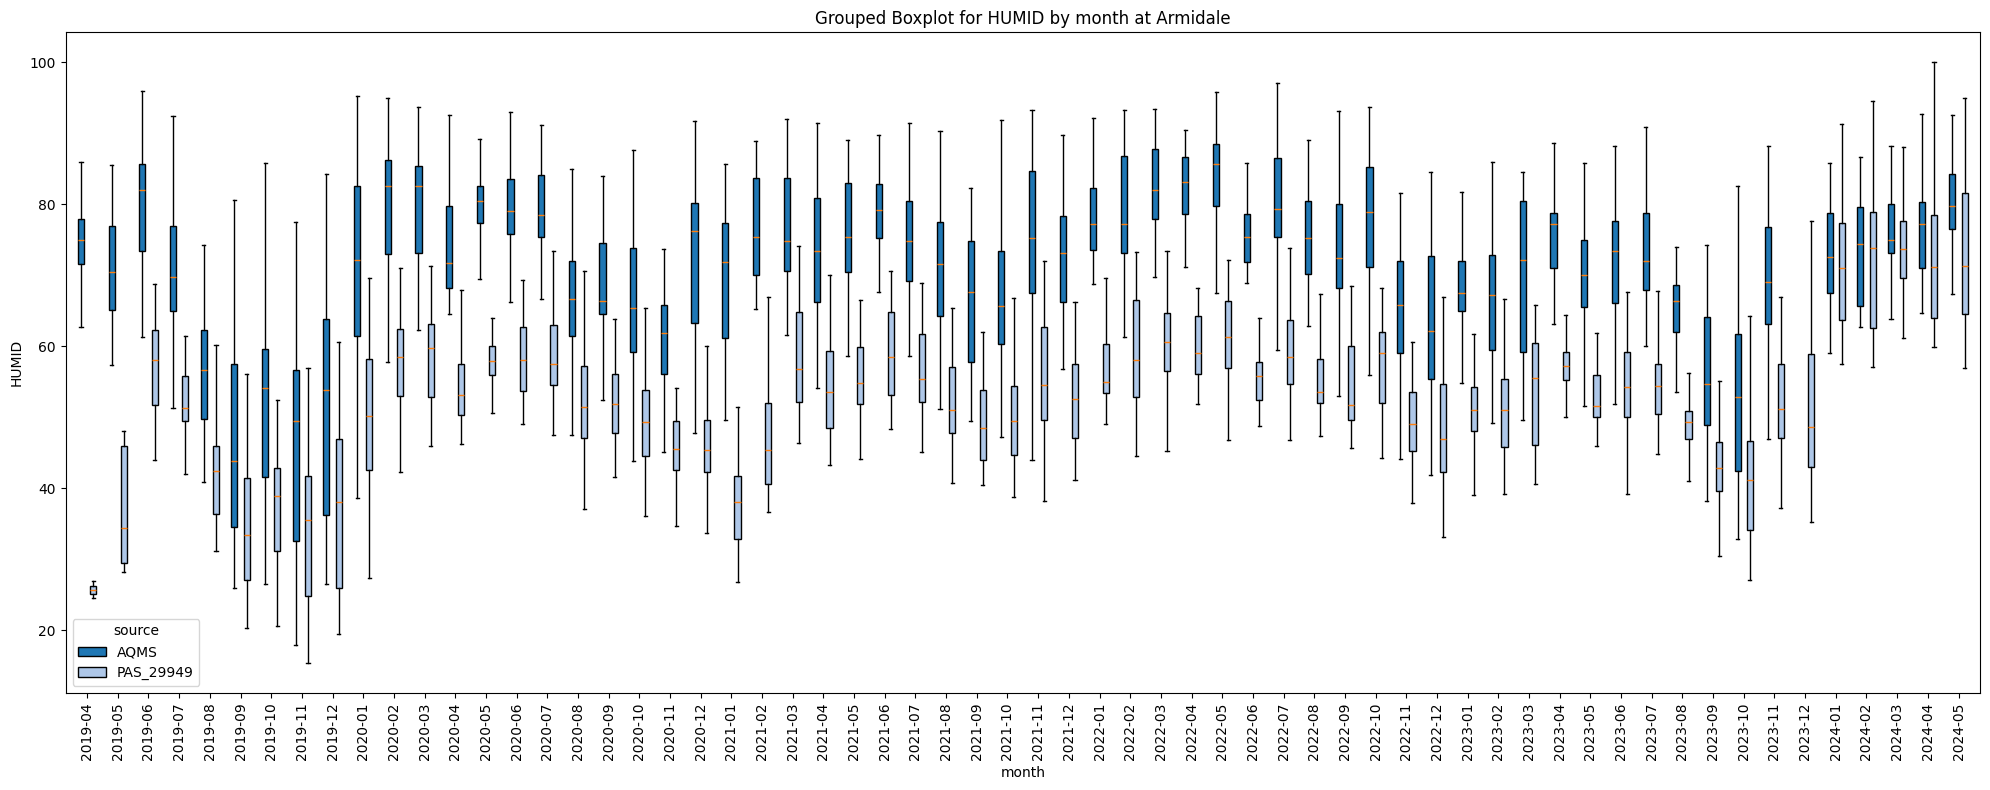

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  TEMP     source    month
datetime_utc                                            
2019-04-01 00:00:00+00:00  13.514083       AQMS  2019-04
2019-04-02 00:00:00+00:00  13.291625       AQMS  2019-04
2019-04-03 00:00:00+00:00  14.544542       AQMS  2019-04
2019-04-04 00:00:00+00:00  14.532833       AQMS  2019-04
2019-04-05 00:00:00+00:00  14.585750       AQMS  2019-04
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  14.400000  PAS_29949  2024-05
2024-05-26 00:00:00+00:00  14.000000  PAS_29949  2024-05
2024-05-27 00:00:00+00:00  12.900000  PAS_29949  2024-05
2024-05-28 00:00:00+00:00  13.100000  PAS_29949  2024-05
2024-05-29 00:00:00+00:00  12.500000  PAS_29949  2024-05

[3719 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


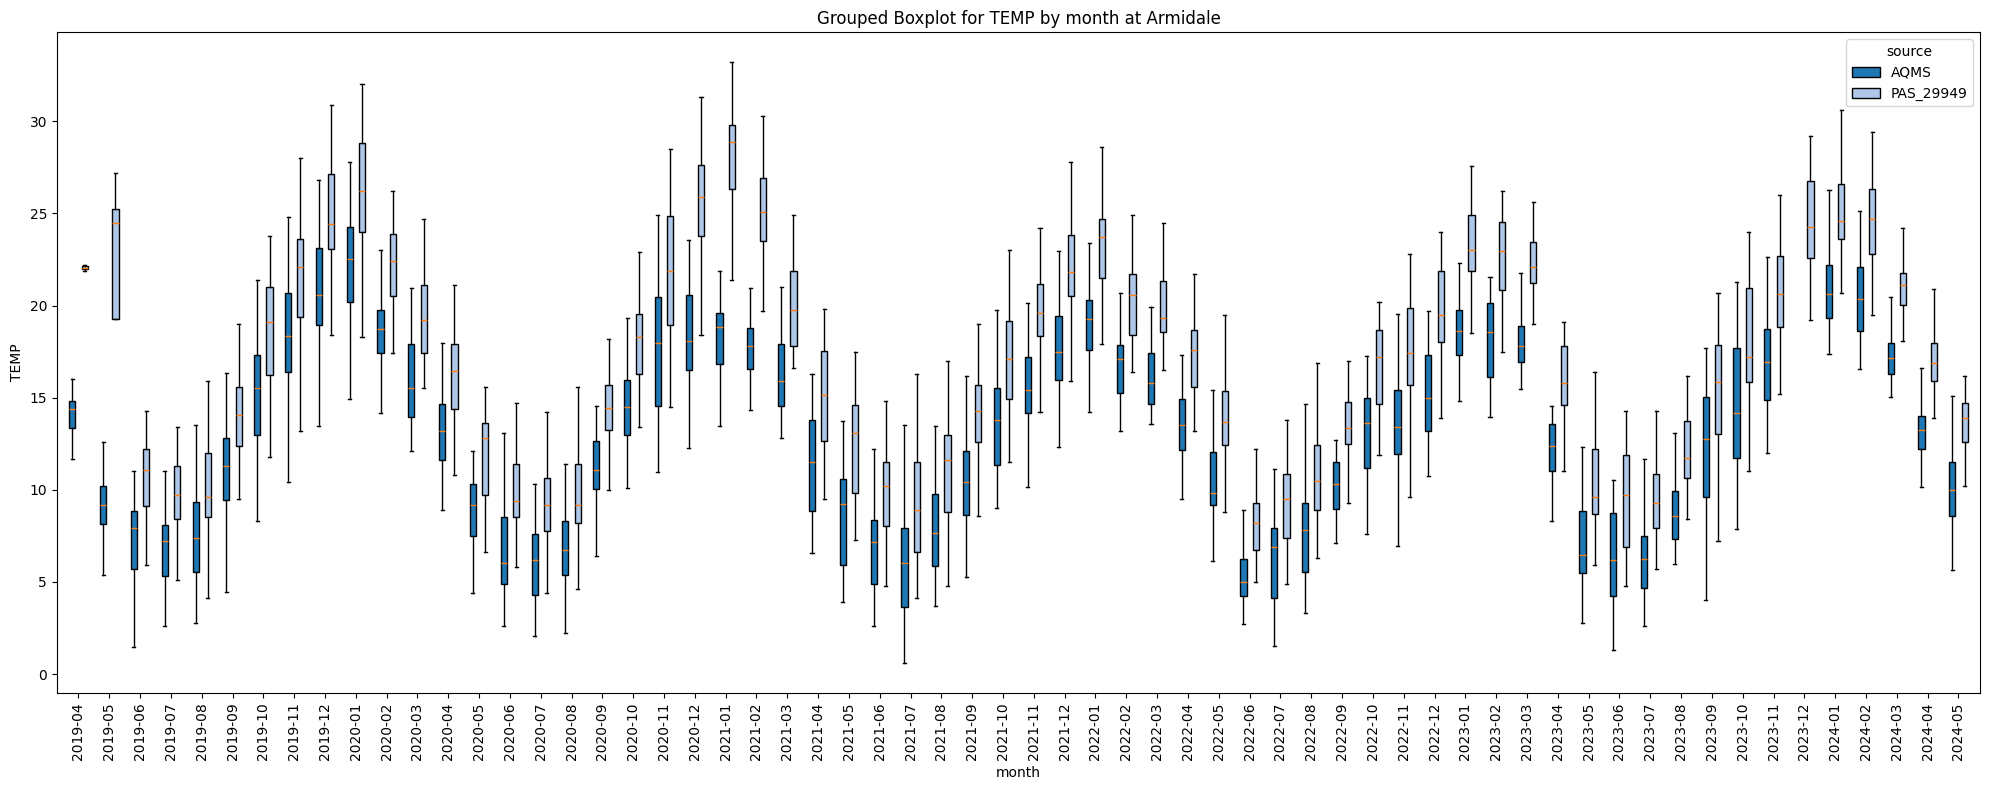

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
COL PAS LIST PAram1:  pm2.5_alt
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_alt
COL PAS LIST PAram1:  pm2.5_corrected
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_corrected
boxplot data:                                 PM2.5               source    month
datetime_utc                                                      
2019-04-01 00:00:00+00:00   3.120200                 AQMS  2019-04
2019-04-02 00:00:00+00:00   2.279667                 AQMS  2019-04
2019-04-03 00:00:00+00:00   3.109000                 AQMS  2019-04
2019-04-04 00:00:00+00:00   0.985000                 AQMS  2019-04
2019-04-05 00:00:00+00:00   2.092000                 AQMS  2019-0

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


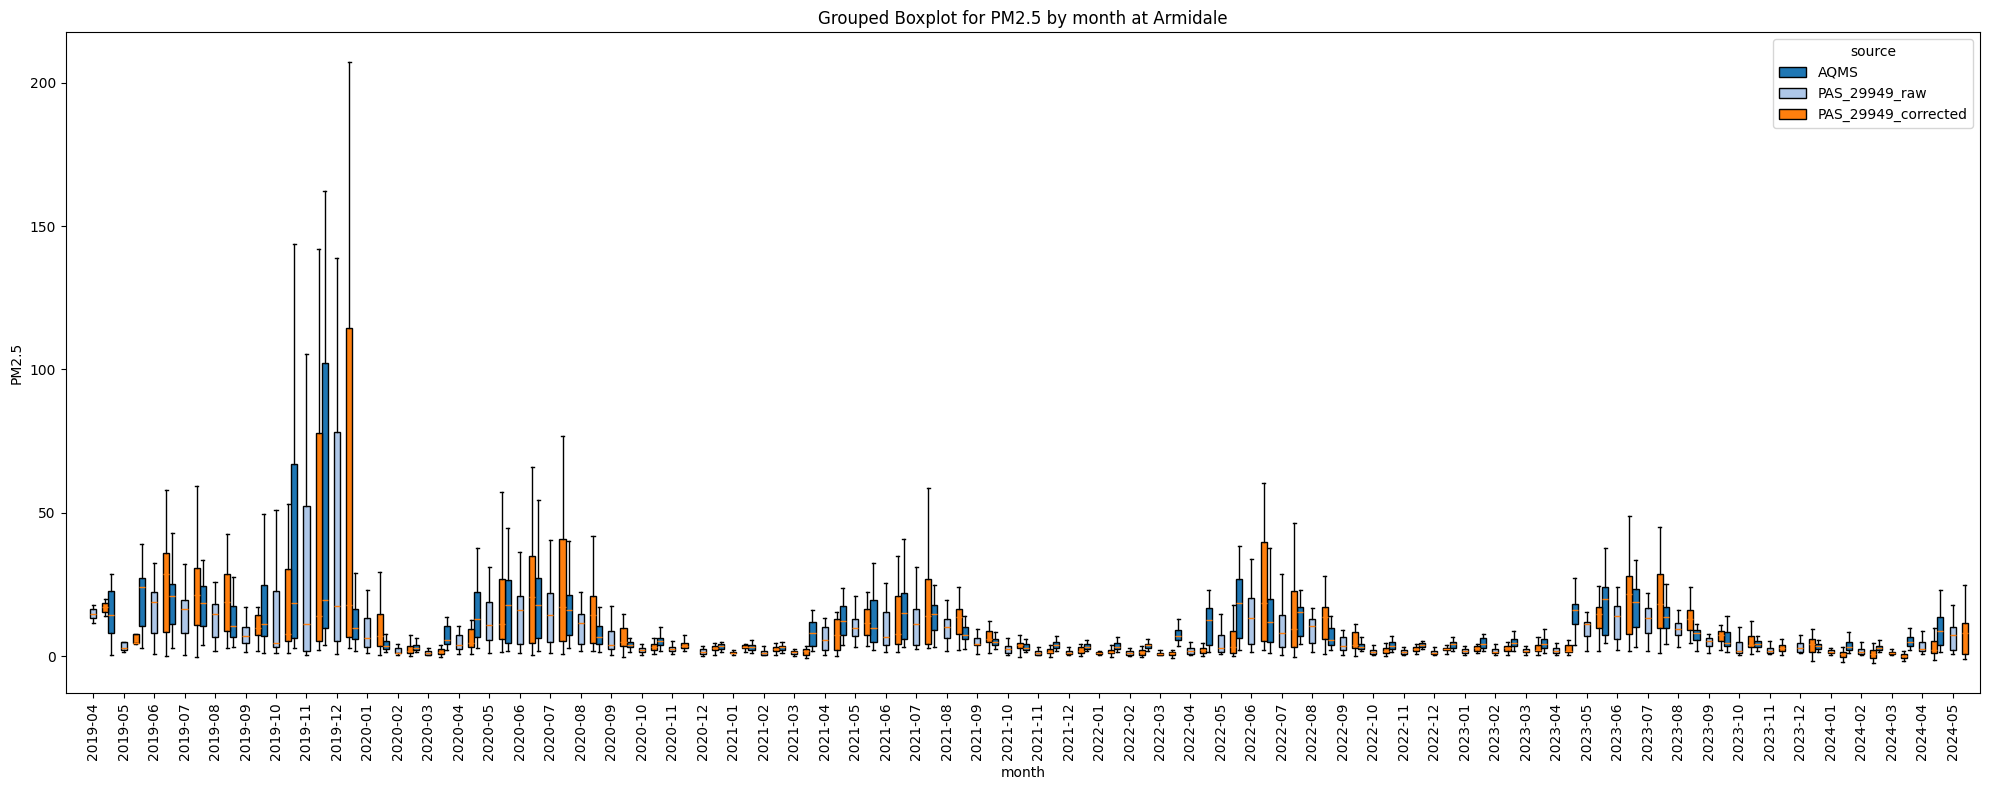

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  PM10     source    month
datetime_utc                                            
2019-04-01 00:00:00+00:00   6.530667       AQMS  2019-04
2019-04-02 00:00:00+00:00   2.098429       AQMS  2019-04
2019-04-03 00:00:00+00:00   2.663882       AQMS  2019-04
2019-04-04 00:00:00+00:00   2.934375       AQMS  2019-04
2019-04-05 00:00:00+00:00   1.893818       AQMS  2019-04
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  19.362000  PAS_29949  2024-05
2024-05-26 00:00:00+00:00  22.198000  PAS_29949  2024-05
2024-05-27 00:00:00+00:00  31.071000  PAS_29949  2024-05
2024-05-28 00:00:00+00:00  37.966000  PAS_29949  2024-05
2024-05-29 00:00:00+00:00  43.762000  PAS_29949  2024-05

[3719 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


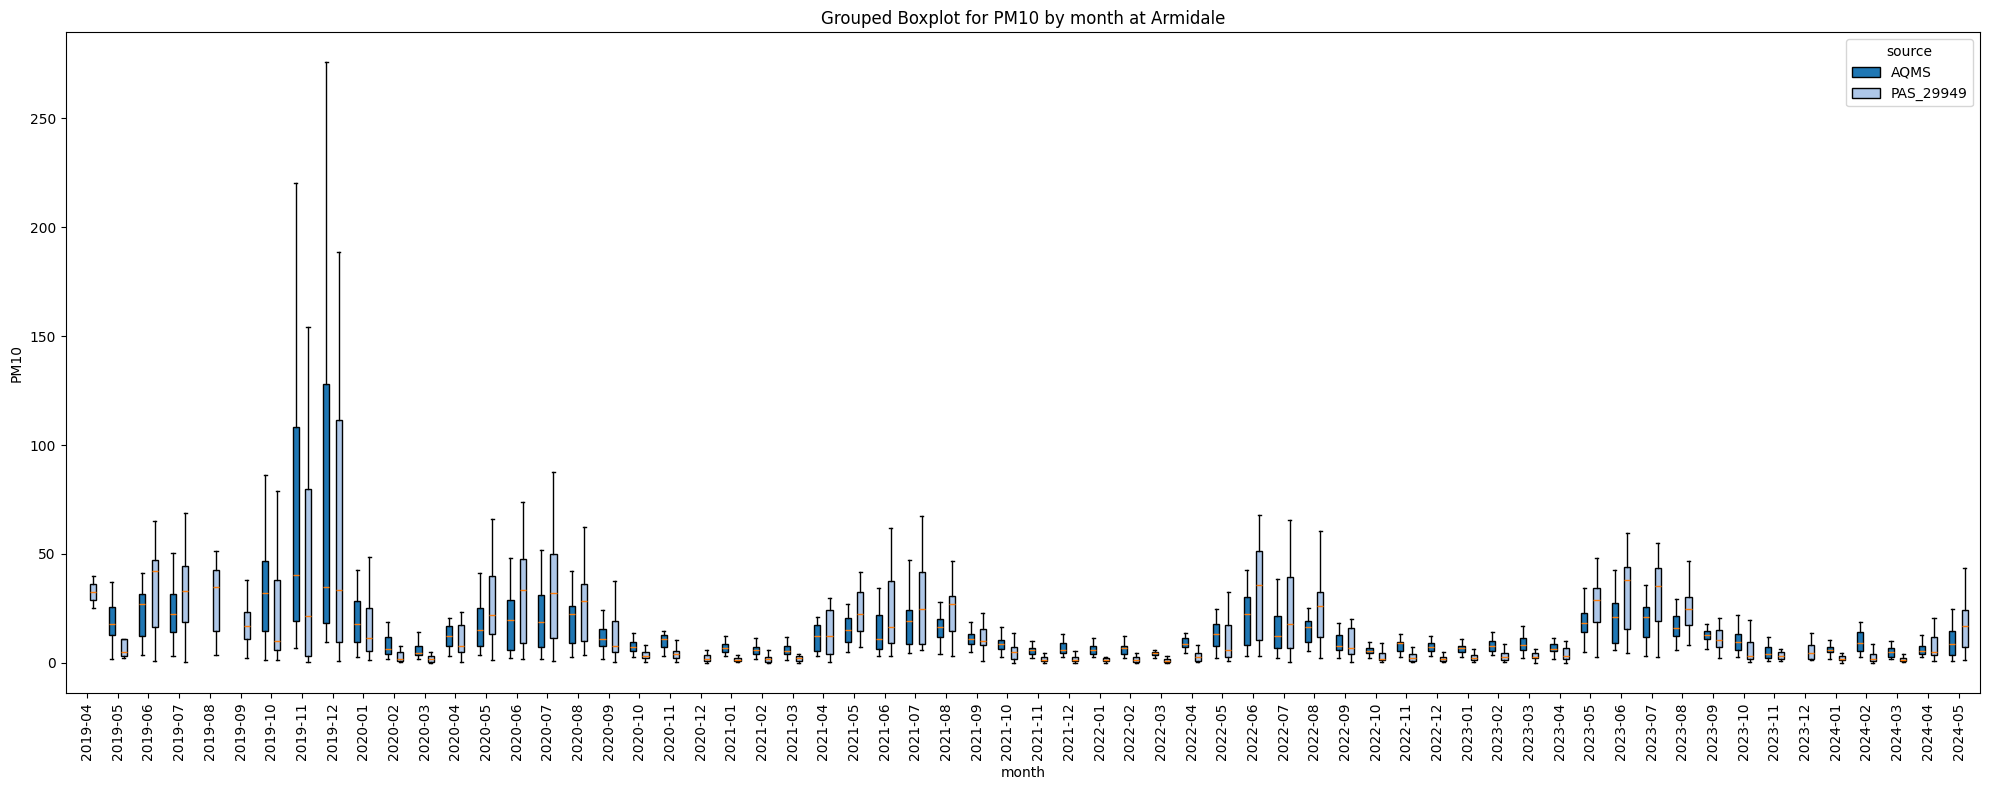

Site:  Bathurst
DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                 HUMID     source    month
datetime_utc                                            
2021-05-01 00:00:00+00:00  74.569625       AQMS  2021-05
2021-05-02 00:00:00+00:00  81.650958       AQMS  2021-05
2021-05-03 00:00:00+00:00  84.525667       AQMS  2021-05
2021-05-04 00:00:00+00:00  90.694167       AQMS  2021-05
2021-05-05 00:00:00+00:00  83.581333       AQMS  2021-05
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  62.755000  PAS_98435  2024-05
2024-05-26 00:00:00+00:00  65.996000  PAS_98435  2024-05
2024-05-27 00:00:00+00:00  60.597000  PAS_98435  2024-05
2024-05-28 00:00:00+00:00  56.489000  PAS_98435  2024-05
2024-05-29 00:00:00+00:00  58.001000  PAS_98435  2024-05

[2191 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


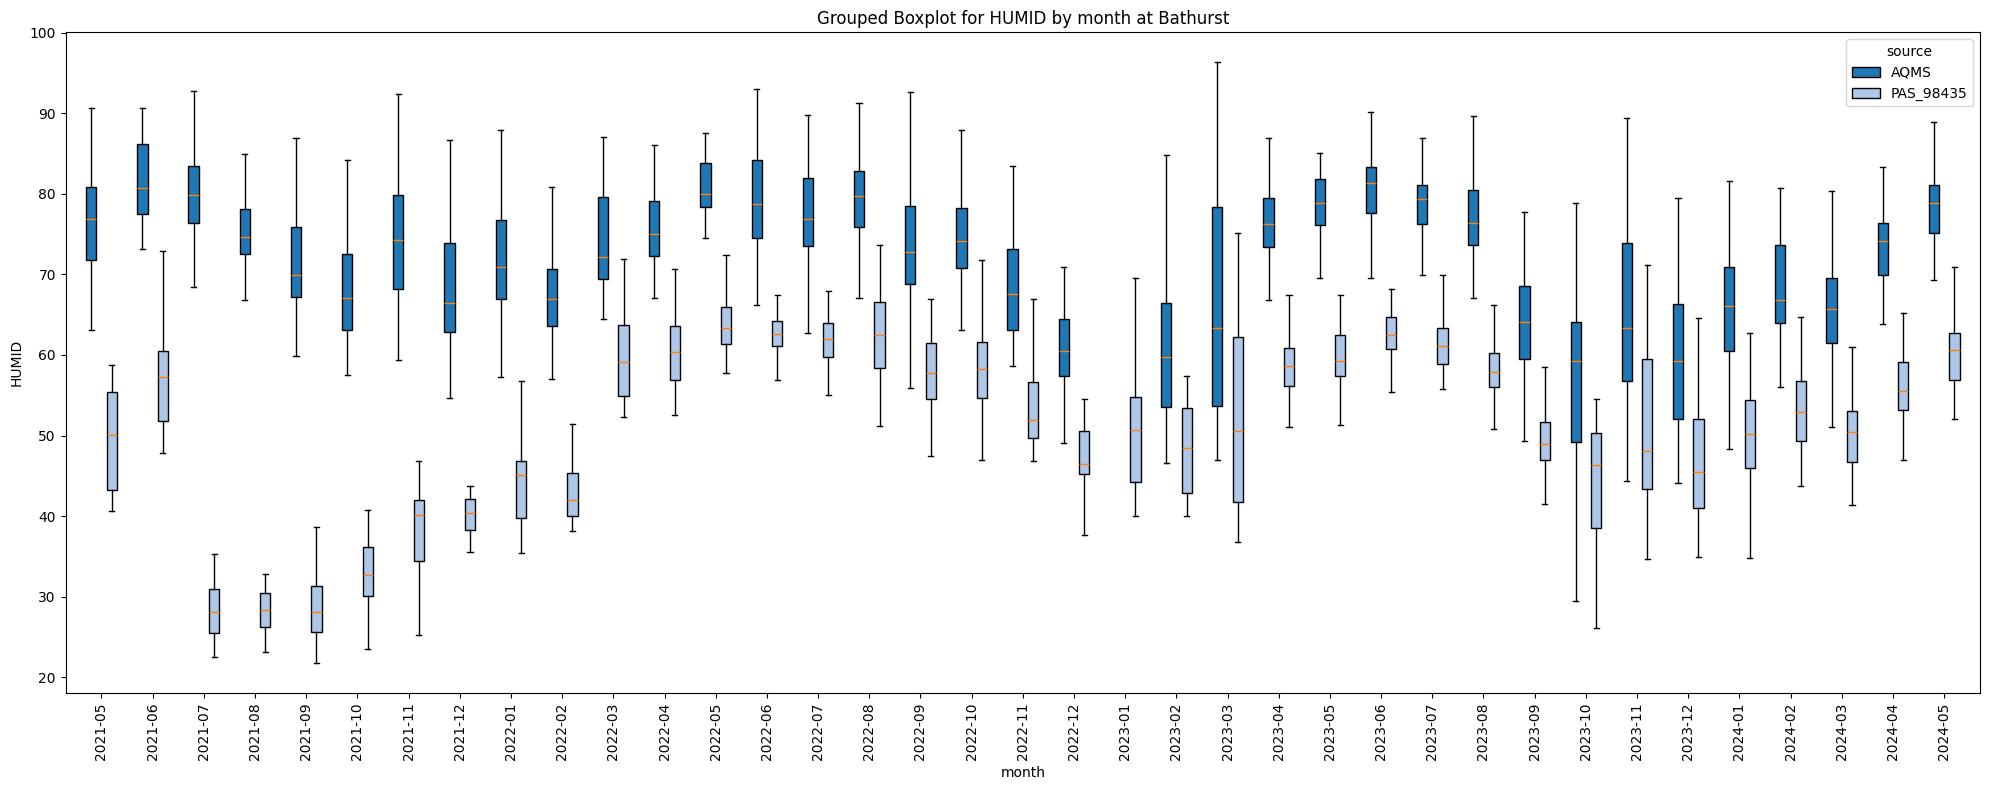

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  TEMP     source    month
datetime_utc                                            
2021-05-01 00:00:00+00:00  11.709042       AQMS  2021-05
2021-05-02 00:00:00+00:00  10.277000       AQMS  2021-05
2021-05-03 00:00:00+00:00  12.165625       AQMS  2021-05
2021-05-04 00:00:00+00:00  10.276792       AQMS  2021-05
2021-05-05 00:00:00+00:00  12.193542       AQMS  2021-05
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  11.900000  PAS_98435  2024-05
2024-05-26 00:00:00+00:00   9.500000  PAS_98435  2024-05
2024-05-27 00:00:00+00:00   8.800000  PAS_98435  2024-05
2024-05-28 00:00:00+00:00   9.900000  PAS_98435  2024-05
2024-05-29 00:00:00+00:00  11.000000  PAS_98435  2024-05

[2191 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


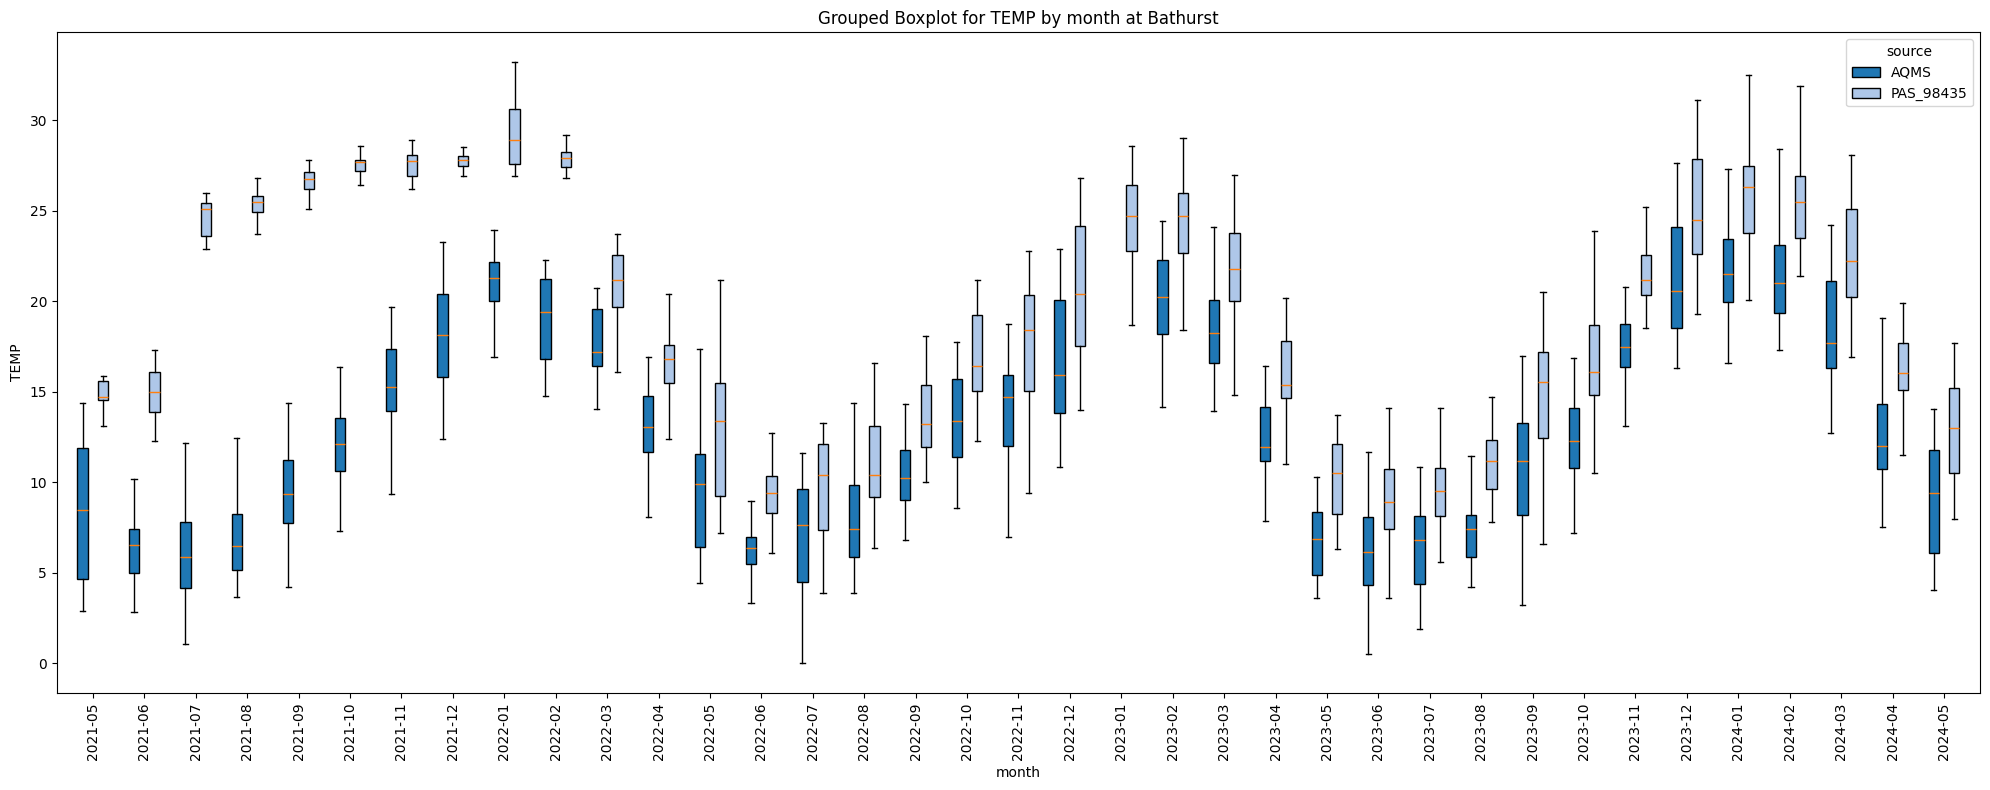

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
COL PAS LIST PAram1:  pm2.5_alt
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_alt
COL PAS LIST PAram1:  pm2.5_corrected
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_corrected
boxplot data:                                 PM2.5               source    month
datetime_utc                                                      
2021-05-01 00:00:00+00:00   9.965208                 AQMS  2021-05
2021-05-02 00:00:00+00:00   6.103826                 AQMS  2021-05
2021-05-03 00:00:00+00:00   7.807000                 AQMS  2021-05
2021-05-04 00:00:00+00:00   3.574913                 AQMS  2021-05
2021-05-05 00:00:00+00:00   4.017100                 AQMS  2021-0

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


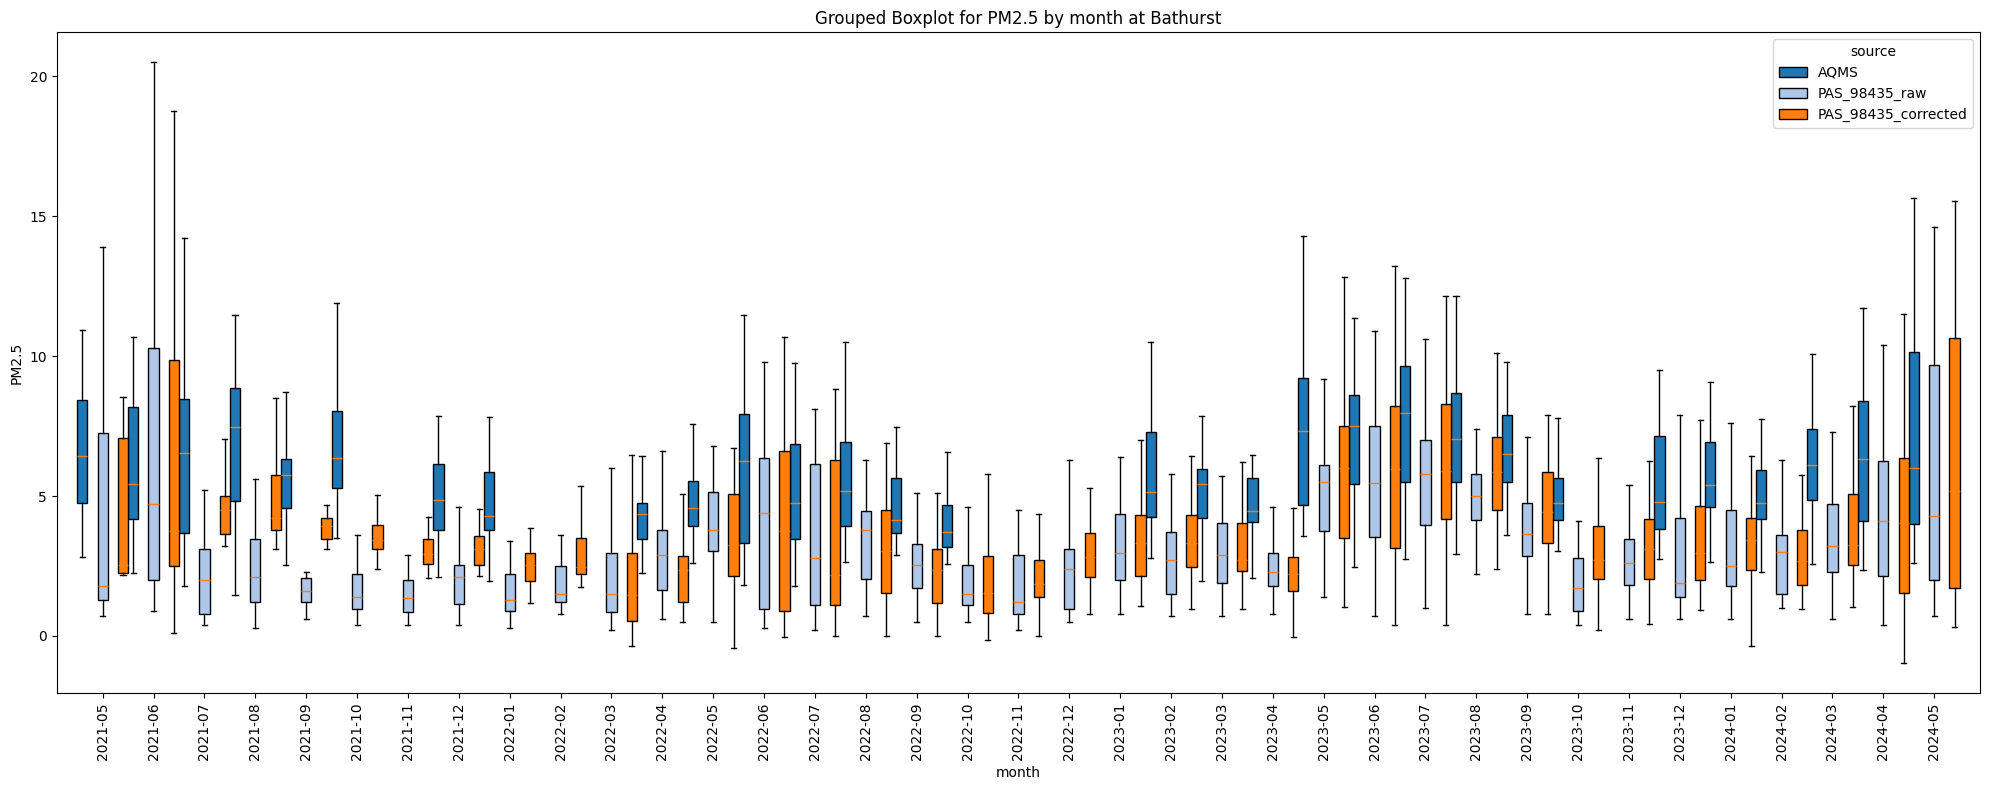

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  PM10     source    month
datetime_utc                                            
2021-05-01 00:00:00+00:00  18.354783       AQMS  2021-05
2021-05-02 00:00:00+00:00  12.650000       AQMS  2021-05
2021-05-03 00:00:00+00:00  14.079417       AQMS  2021-05
2021-05-04 00:00:00+00:00   6.018000       AQMS  2021-05
2021-05-05 00:00:00+00:00   6.452143       AQMS  2021-05
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  27.276000  PAS_98435  2024-05
2024-05-26 00:00:00+00:00  28.658000  PAS_98435  2024-05
2024-05-27 00:00:00+00:00  34.038000  PAS_98435  2024-05
2024-05-28 00:00:00+00:00  27.998000  PAS_98435  2024-05
2024-05-29 00:00:00+00:00  23.876000  PAS_98435  2024-05

[2191 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


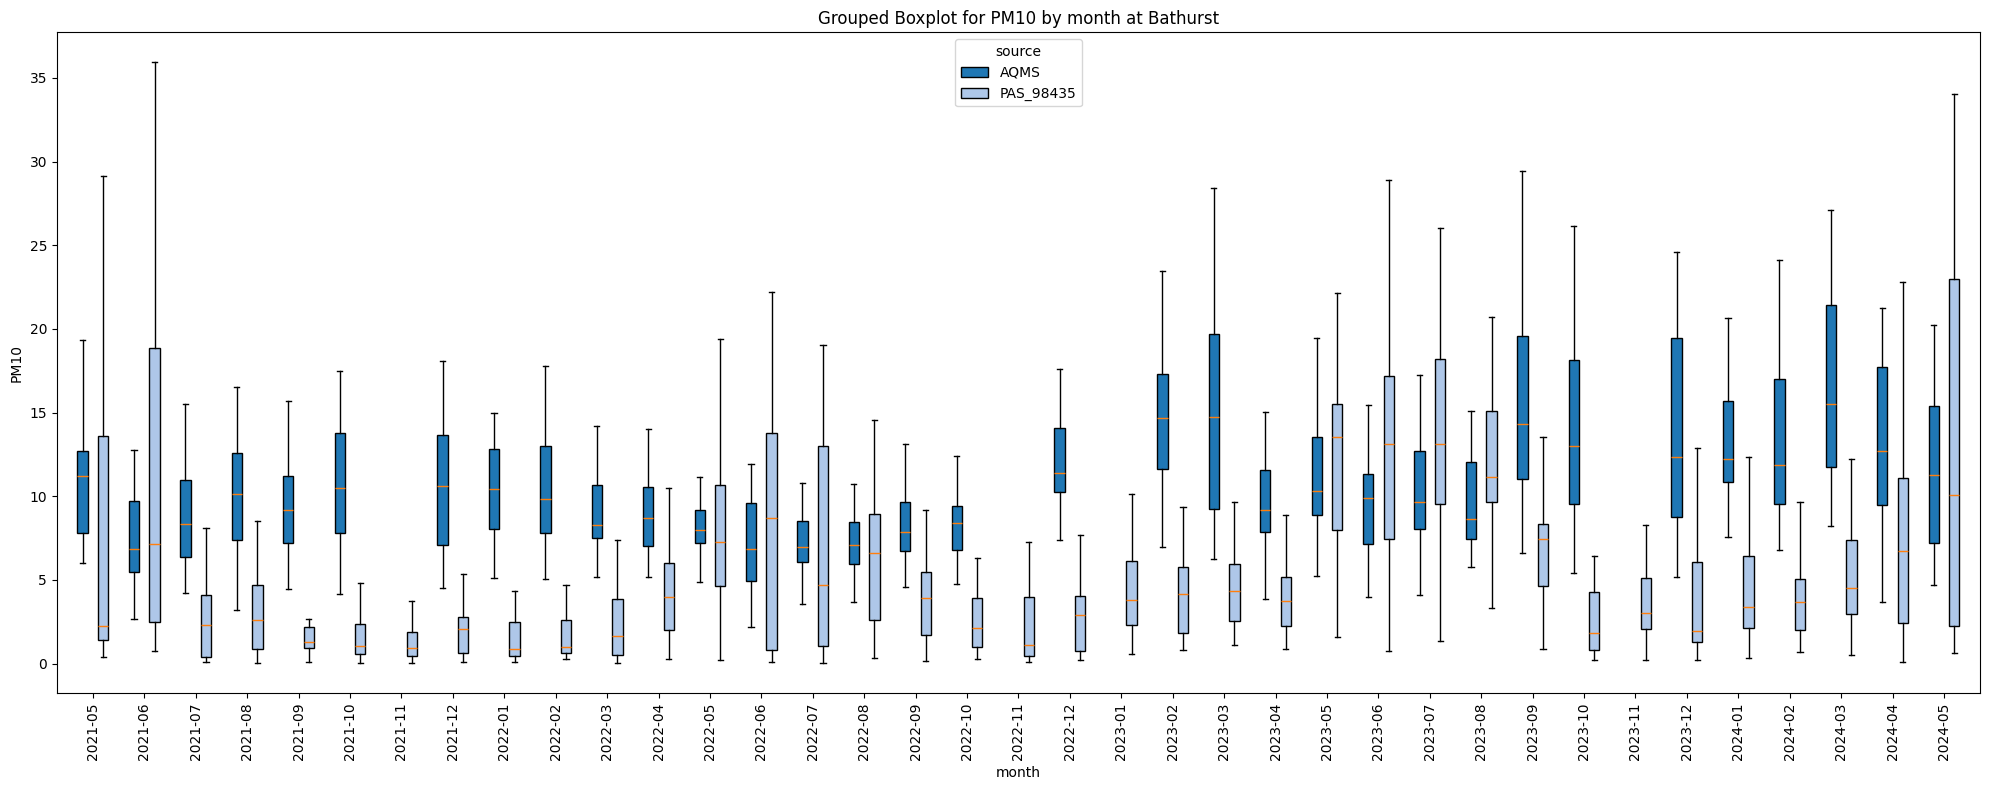

Site:  Lidcombe
DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                 HUMID     source    month
datetime_utc                                            
2021-02-28 00:00:00+00:00  88.666100       AQMS  2021-02
2021-03-01 00:00:00+00:00  66.566875       AQMS  2021-03
2021-03-02 00:00:00+00:00  58.344435       AQMS  2021-03
2021-03-03 00:00:00+00:00  63.645250       AQMS  2021-03
2021-03-04 00:00:00+00:00  60.290417       AQMS  2021-03
...                              ...        ...      ...
2023-12-25 00:00:00+00:00  63.311000  PAS_91355  2023-12
2023-12-26 00:00:00+00:00  63.157000  PAS_91355  2023-12
2023-12-27 00:00:00+00:00  62.755000  PAS_91355  2023-12
2023-12-28 00:00:00+00:00  53.186000  PAS_91355  2023-12
2023-12-29 00:00:00+00:00  54.240000  PAS_91355  2023-12

[4054 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")
C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\4061503502.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


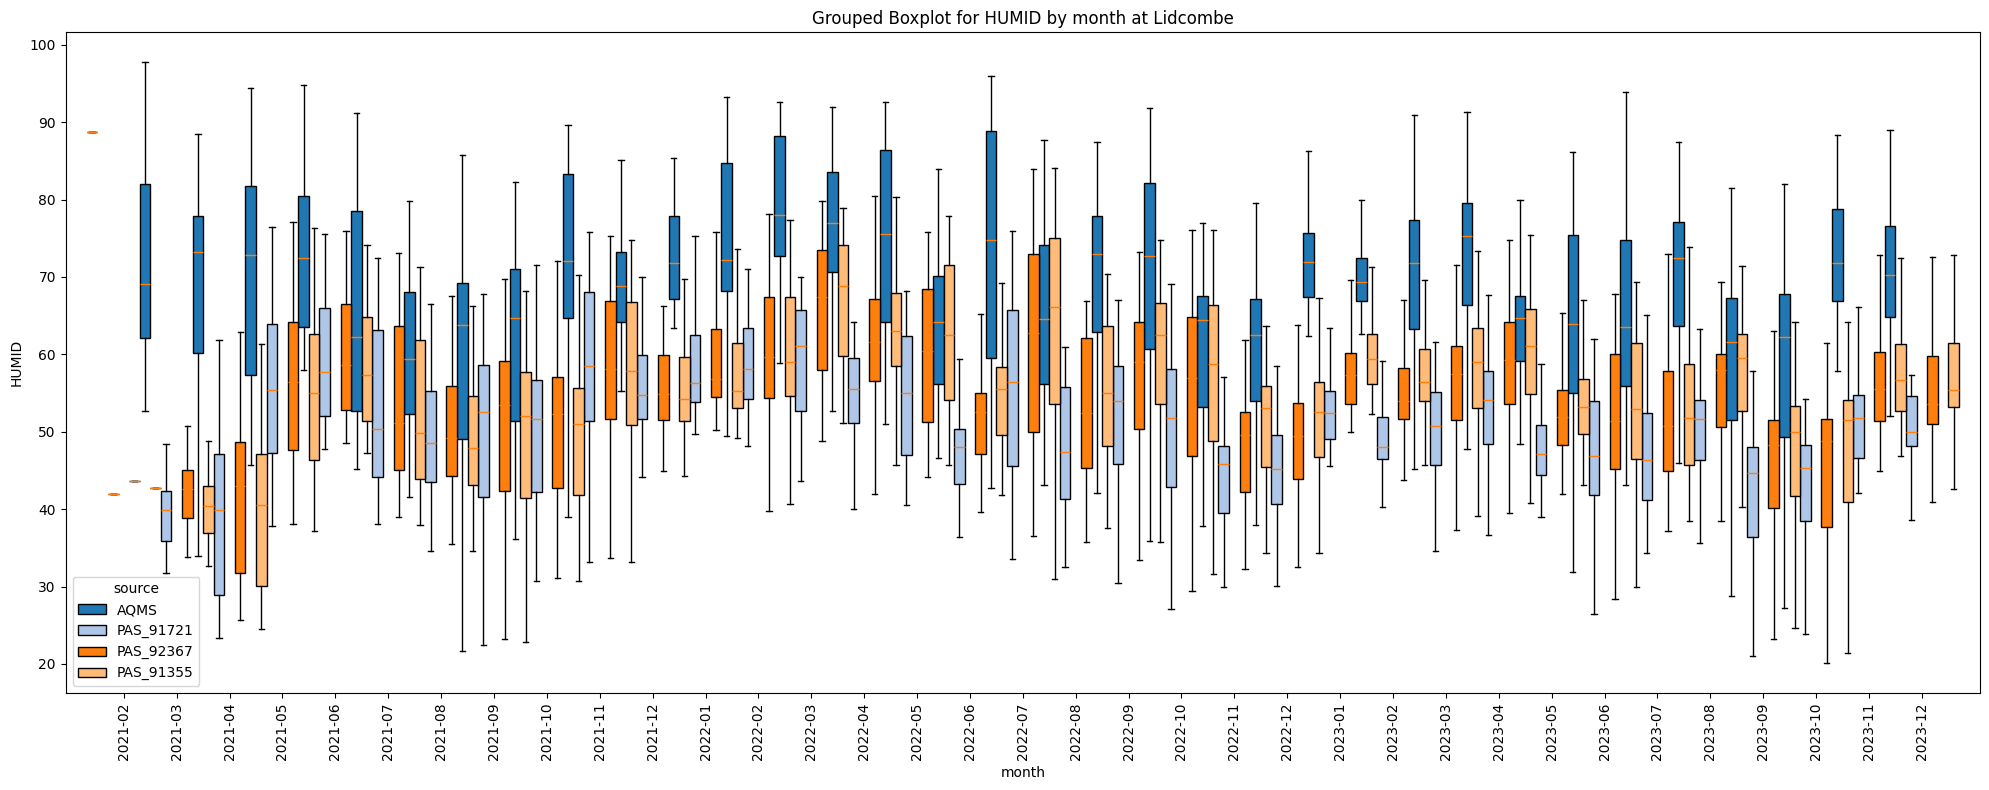

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  TEMP     source    month
datetime_utc                                            
2021-02-28 00:00:00+00:00  21.307600       AQMS  2021-02
2021-03-01 00:00:00+00:00  25.288125       AQMS  2021-03
2021-03-02 00:00:00+00:00  19.950522       AQMS  2021-03
2021-03-03 00:00:00+00:00  18.724750       AQMS  2021-03
2021-03-04 00:00:00+00:00  21.963917       AQMS  2021-03
...                              ...        ...      ...
2023-12-25 00:00:00+00:00  25.900000  PAS_91355  2023-12
2023-12-26 00:00:00+00:00  25.700000  PAS_91355  2023-12
2023-12-27 00:00:00+00:00  23.200000  PAS_91355  2023-12
2023-12-28 00:00:00+00:00  26.200000  PAS_91355  2023-12
2023-12-29 00:00:00+00:00  25.100000  PAS_91355  2023-12

[4054 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


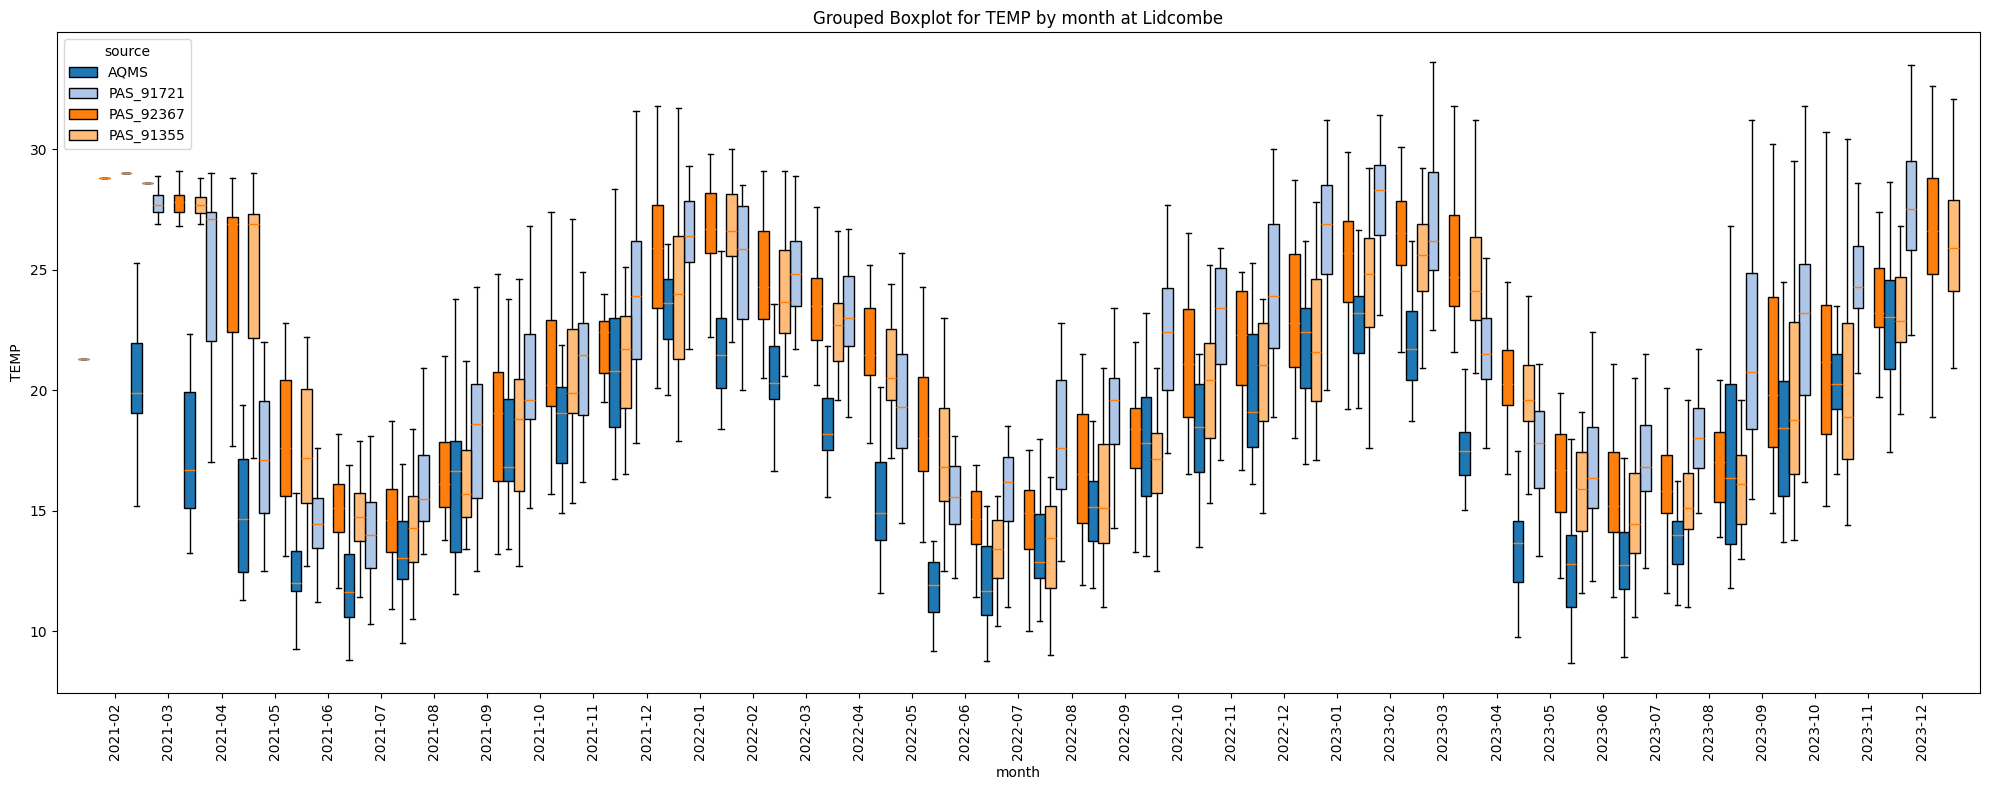

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
COL PAS LIST PAram1:  pm2.5_alt
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_alt
COL PAS LIST PAram1:  pm2.5_corrected
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_corrected
COL PAS LIST PAram1:  pm2.5_alt
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_alt
COL PAS LIST PAram1:  pm2.5_corrected
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_corrected
COL PAS LIST PAram1:  pm2.5_al

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


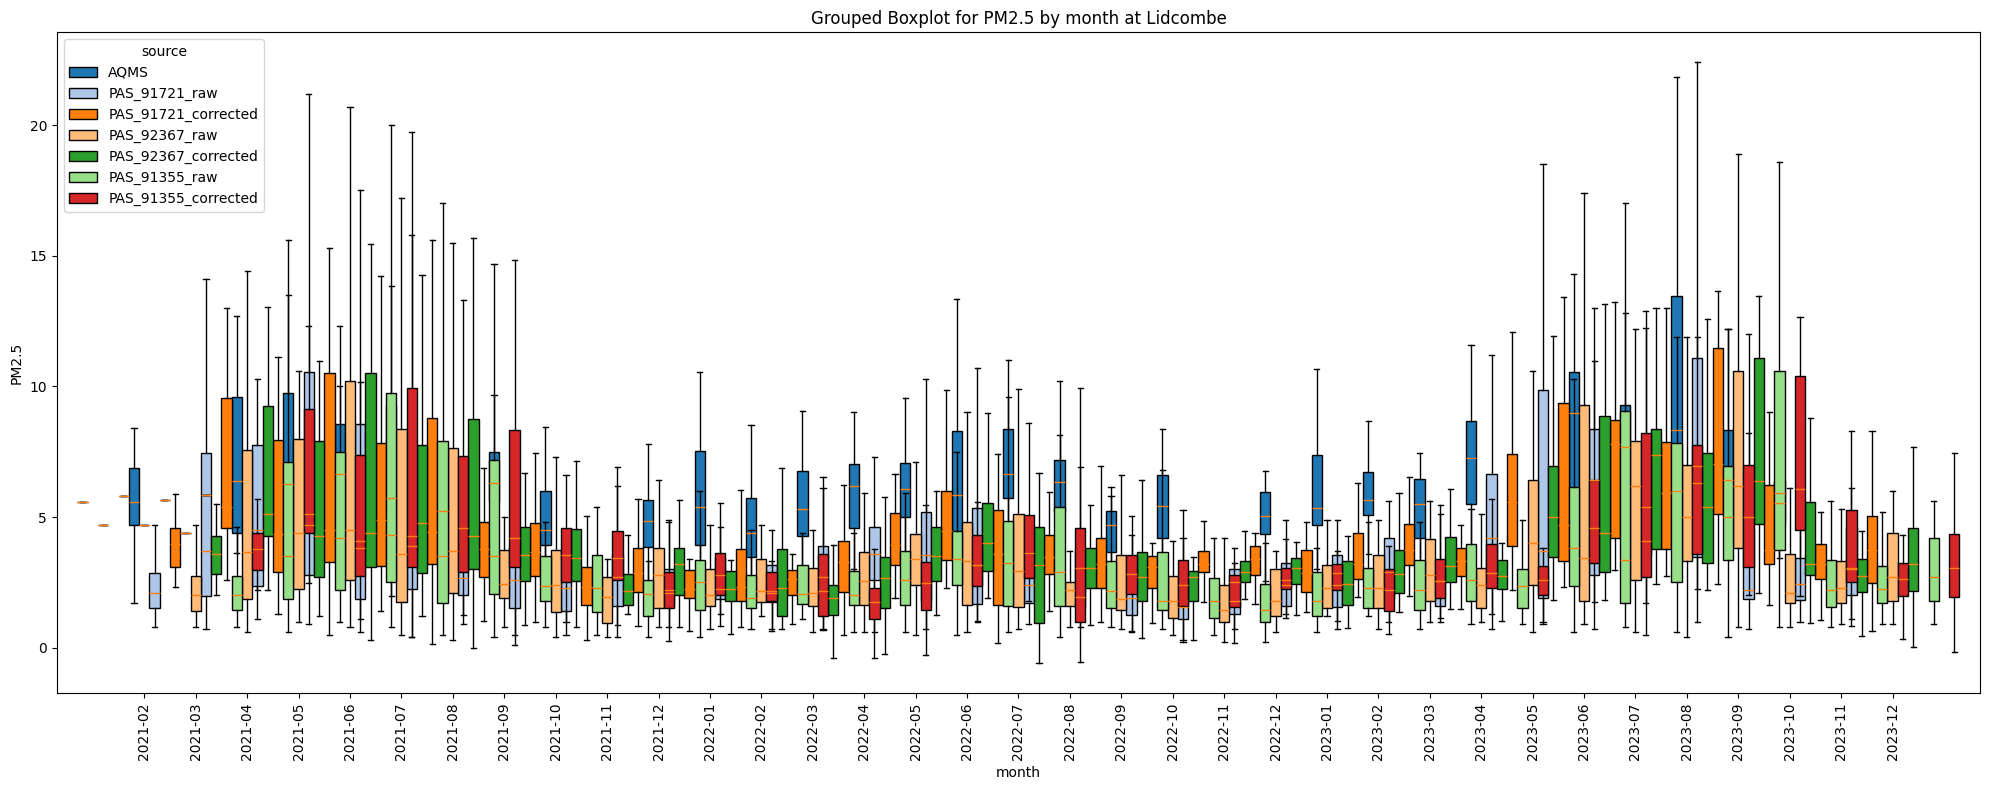

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  PM10     source    month
datetime_utc                                            
2021-02-28 00:00:00+00:00  18.335200       AQMS  2021-02
2021-03-01 00:00:00+00:00  34.344435       AQMS  2021-03
2021-03-02 00:00:00+00:00  25.429136       AQMS  2021-03
2021-03-03 00:00:00+00:00  15.197087       AQMS  2021-03
2021-03-04 00:00:00+00:00  17.318458       AQMS  2021-03
...                              ...        ...      ...
2023-12-25 00:00:00+00:00   3.656000  PAS_91355  2023-12
2023-12-26 00:00:00+00:00   6.330000  PAS_91355  2023-12
2023-12-27 00:00:00+00:00   5.440000  PAS_91355  2023-12
2023-12-28 00:00:00+00:00   3.652000  PAS_91355  2023-12
2023-12-29 00:00:00+00:00   3.709000  PAS_91355  2023-12

[4054 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


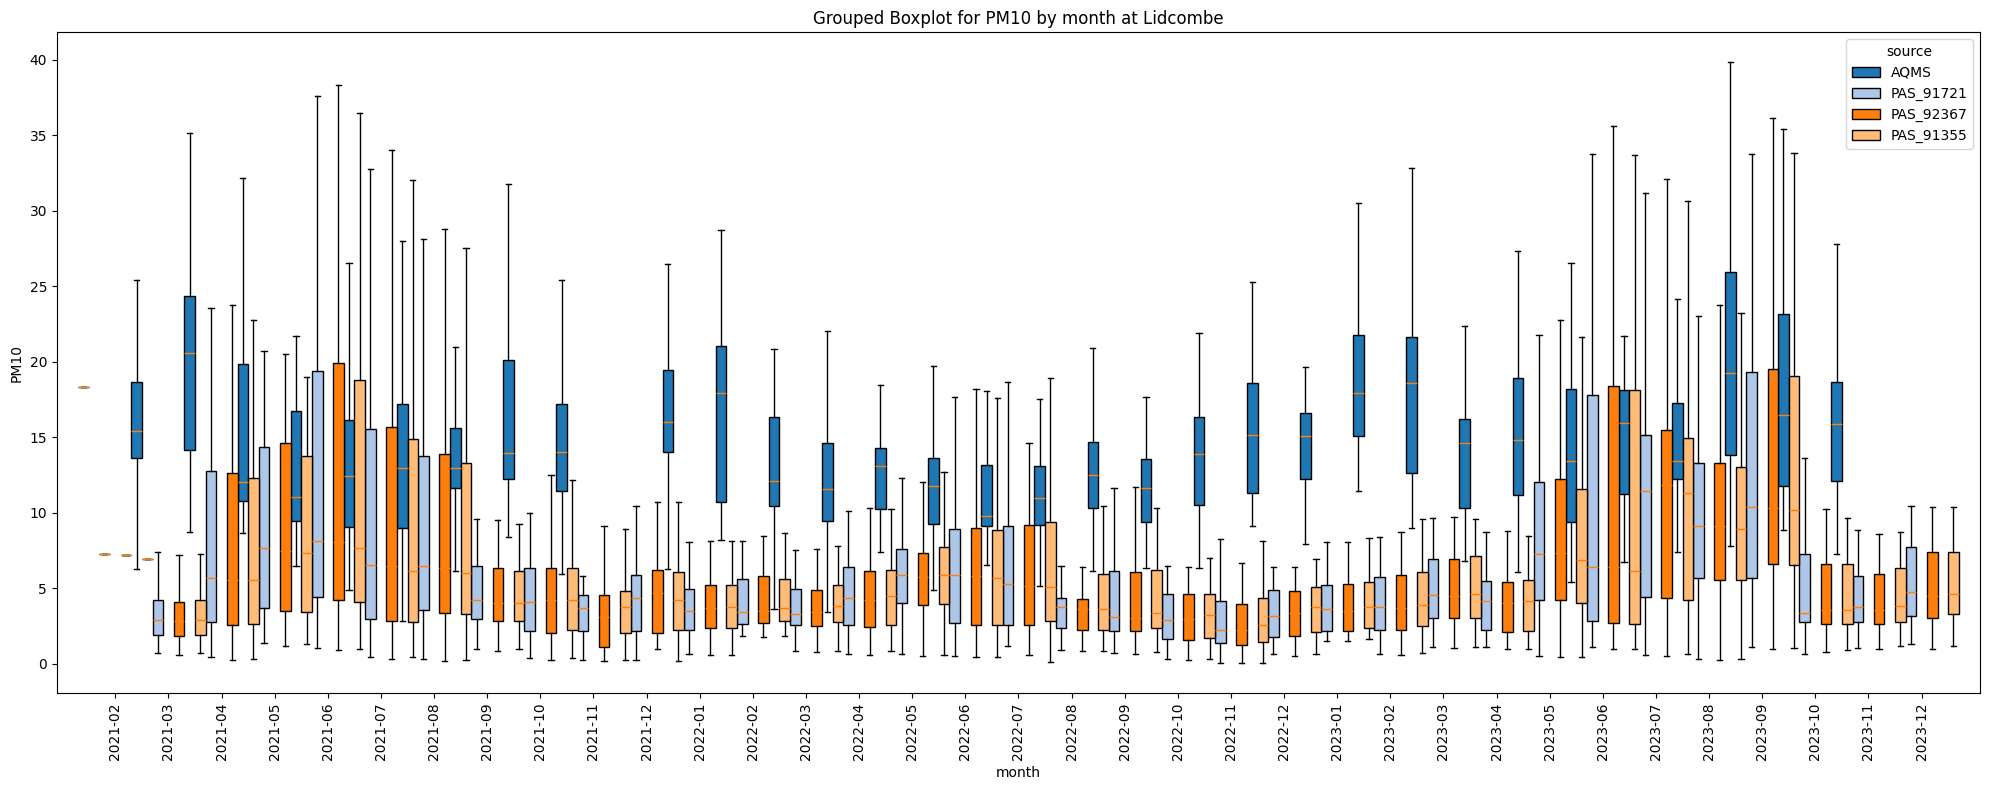

Site:  Millthorpe
DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                 HUMID      source    month
datetime_utc                                             
2023-07-27 00:00:00+00:00  78.638333        AQMS  2023-07
2023-07-28 00:00:00+00:00  76.364800        AQMS  2023-07
2023-07-29 00:00:00+00:00  92.580778        AQMS  2023-07
2023-07-30 00:00:00+00:00  82.991750        AQMS  2023-07
2023-07-31 00:00:00+00:00  82.685625        AQMS  2023-07
...                              ...         ...      ...
2024-05-25 00:00:00+00:00  53.389000  PAS_182853  2024-05
2024-05-26 00:00:00+00:00  51.689000  PAS_182853  2024-05
2024-05-27 00:00:00+00:00  50.799000  PAS_182853  2024-05
2024-05-28 00:00:00+00:00  45.890000  PAS_182853  2024-05
2024-05-29 00:00:00+00:00  48.459000  PAS_182853  2024-05

[617 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


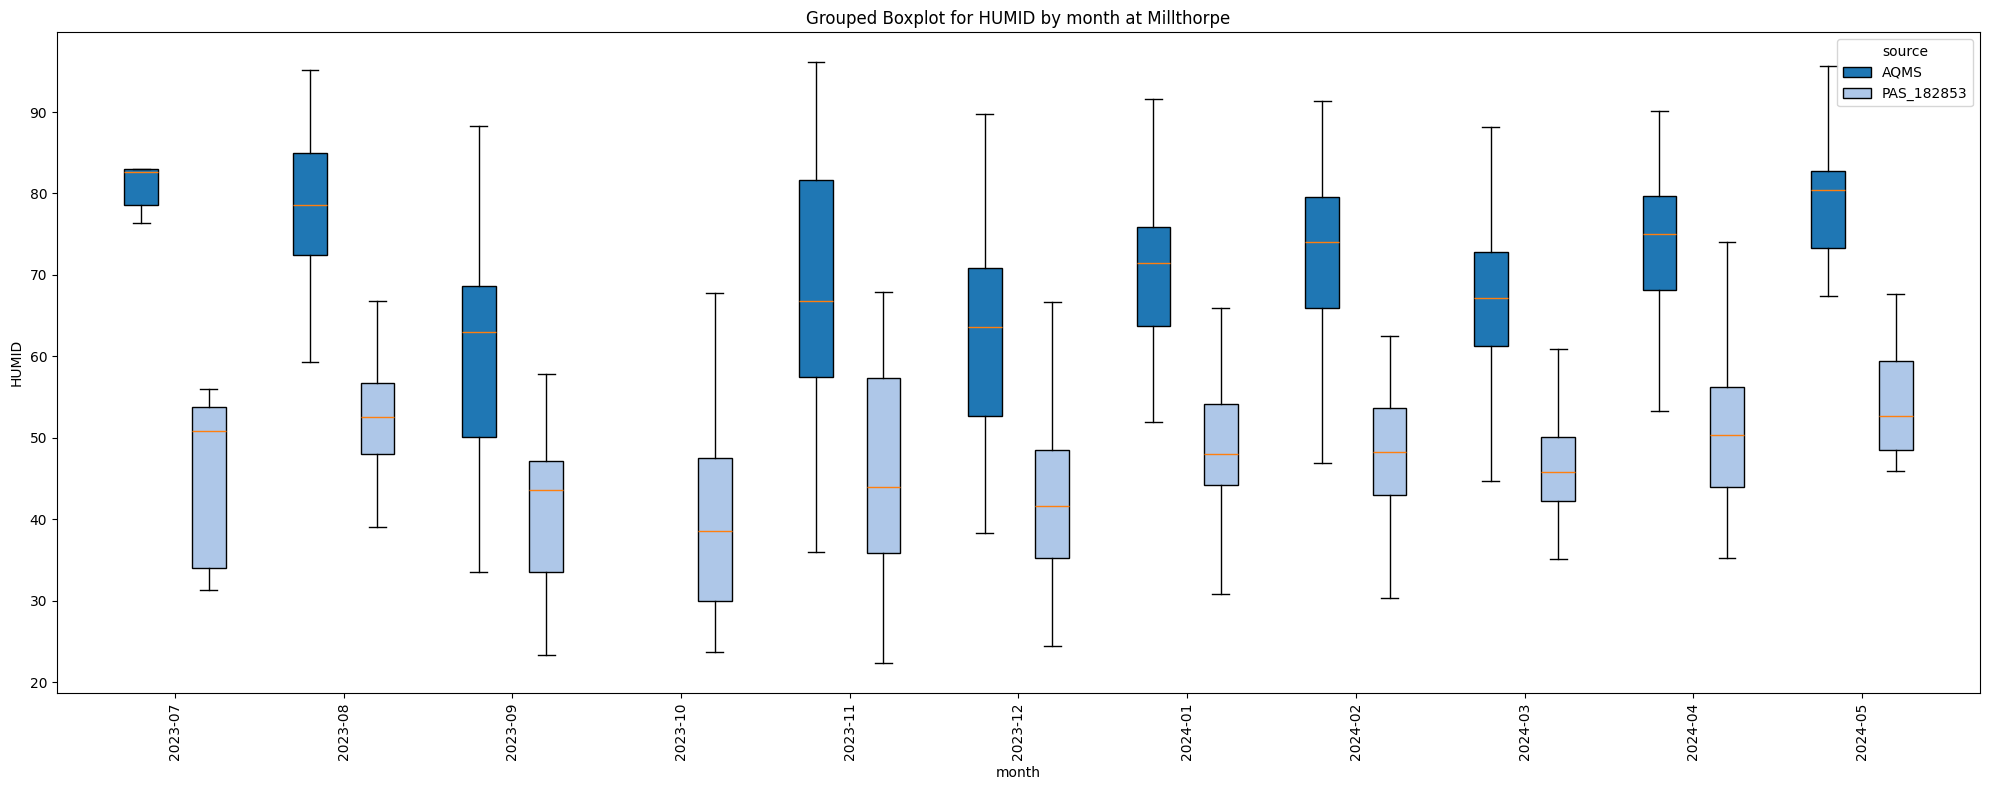

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  TEMP      source    month
datetime_utc                                             
2023-07-27 00:00:00+00:00   7.176667        AQMS  2023-07
2023-07-28 00:00:00+00:00  10.395267        AQMS  2023-07
2023-07-29 00:00:00+00:00   7.998778        AQMS  2023-07
2023-07-30 00:00:00+00:00   9.002417        AQMS  2023-07
2023-07-31 00:00:00+00:00   7.244542        AQMS  2023-07
...                              ...         ...      ...
2024-05-25 00:00:00+00:00  15.000000  PAS_182853  2024-05
2024-05-26 00:00:00+00:00  14.700000  PAS_182853  2024-05
2024-05-27 00:00:00+00:00  13.800000  PAS_182853  2024-05
2024-05-28 00:00:00+00:00  15.700000  PAS_182853  2024-05
2024-05-29 00:00:00+00:00  16.200000  PAS_182853  2024-05

[617 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


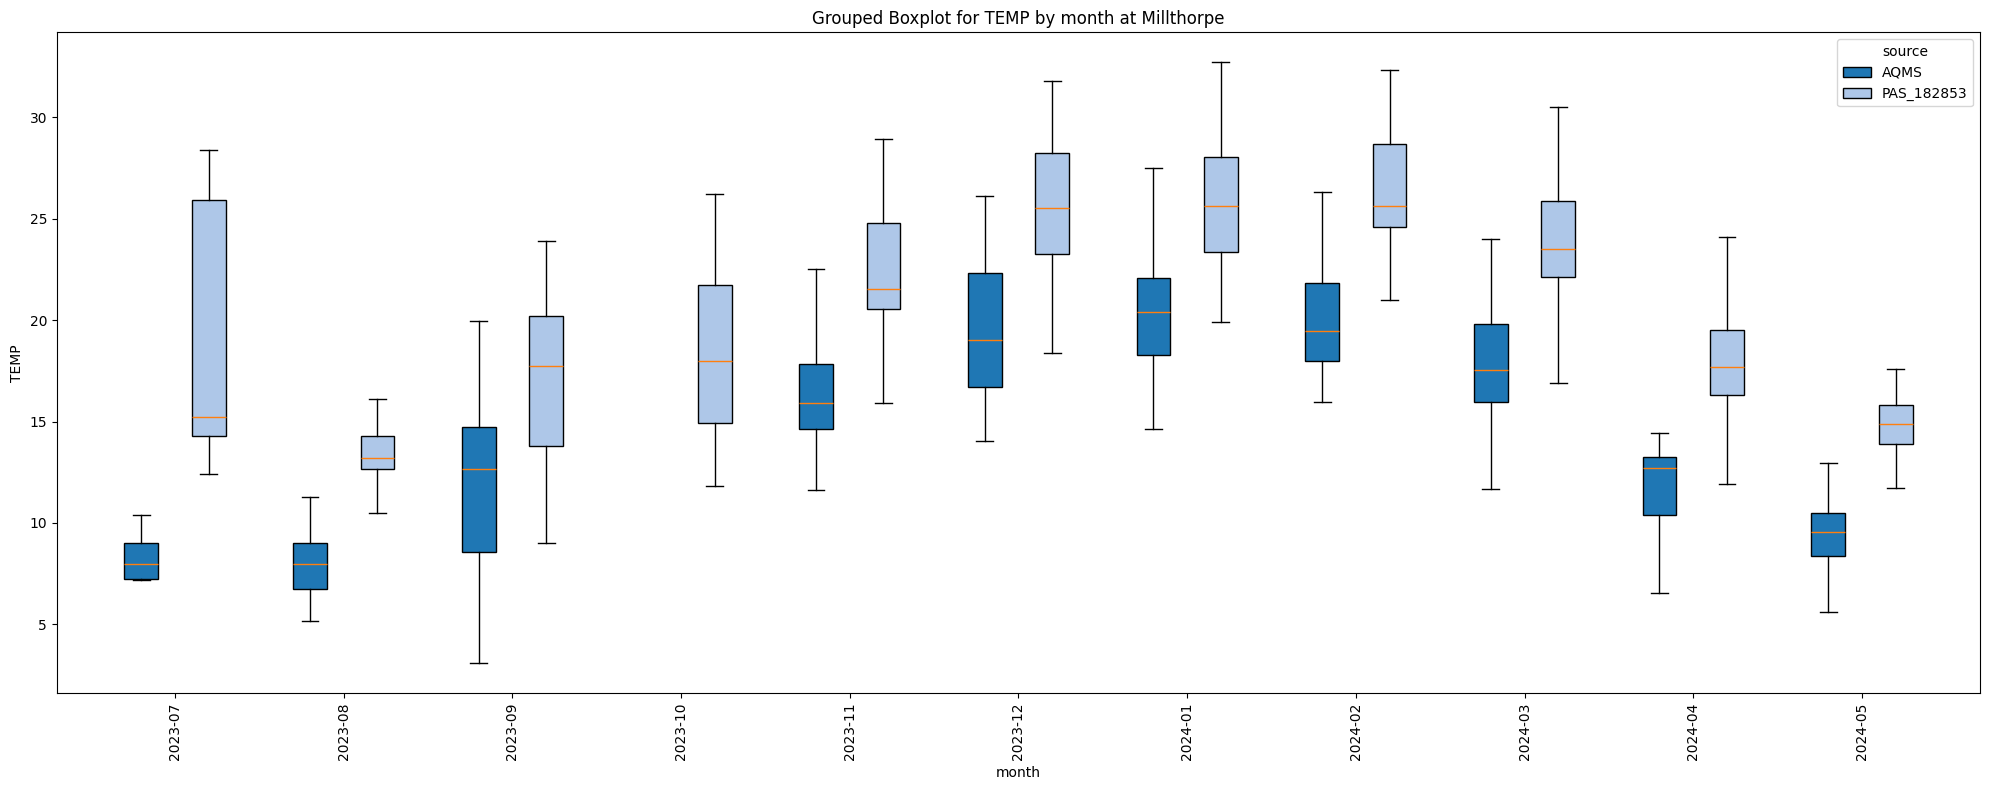

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
COL PAS LIST PAram1:  pm2.5_alt
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_alt
COL PAS LIST PAram1:  pm2.5_corrected
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_corrected
boxplot data:                                 PM2.5                source    month
datetime_utc                                                       
2023-07-27 00:00:00+00:00   6.036000                  AQMS  2023-07
2023-07-28 00:00:00+00:00   6.379067                  AQMS  2023-07
2023-07-29 00:00:00+00:00   7.242889                  AQMS  2023-07
2023-07-30 00:00:00+00:00   8.295167                  AQMS  2023-07
2023-07-31 00:00:00+00:00   4.553458                  AQMS 

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


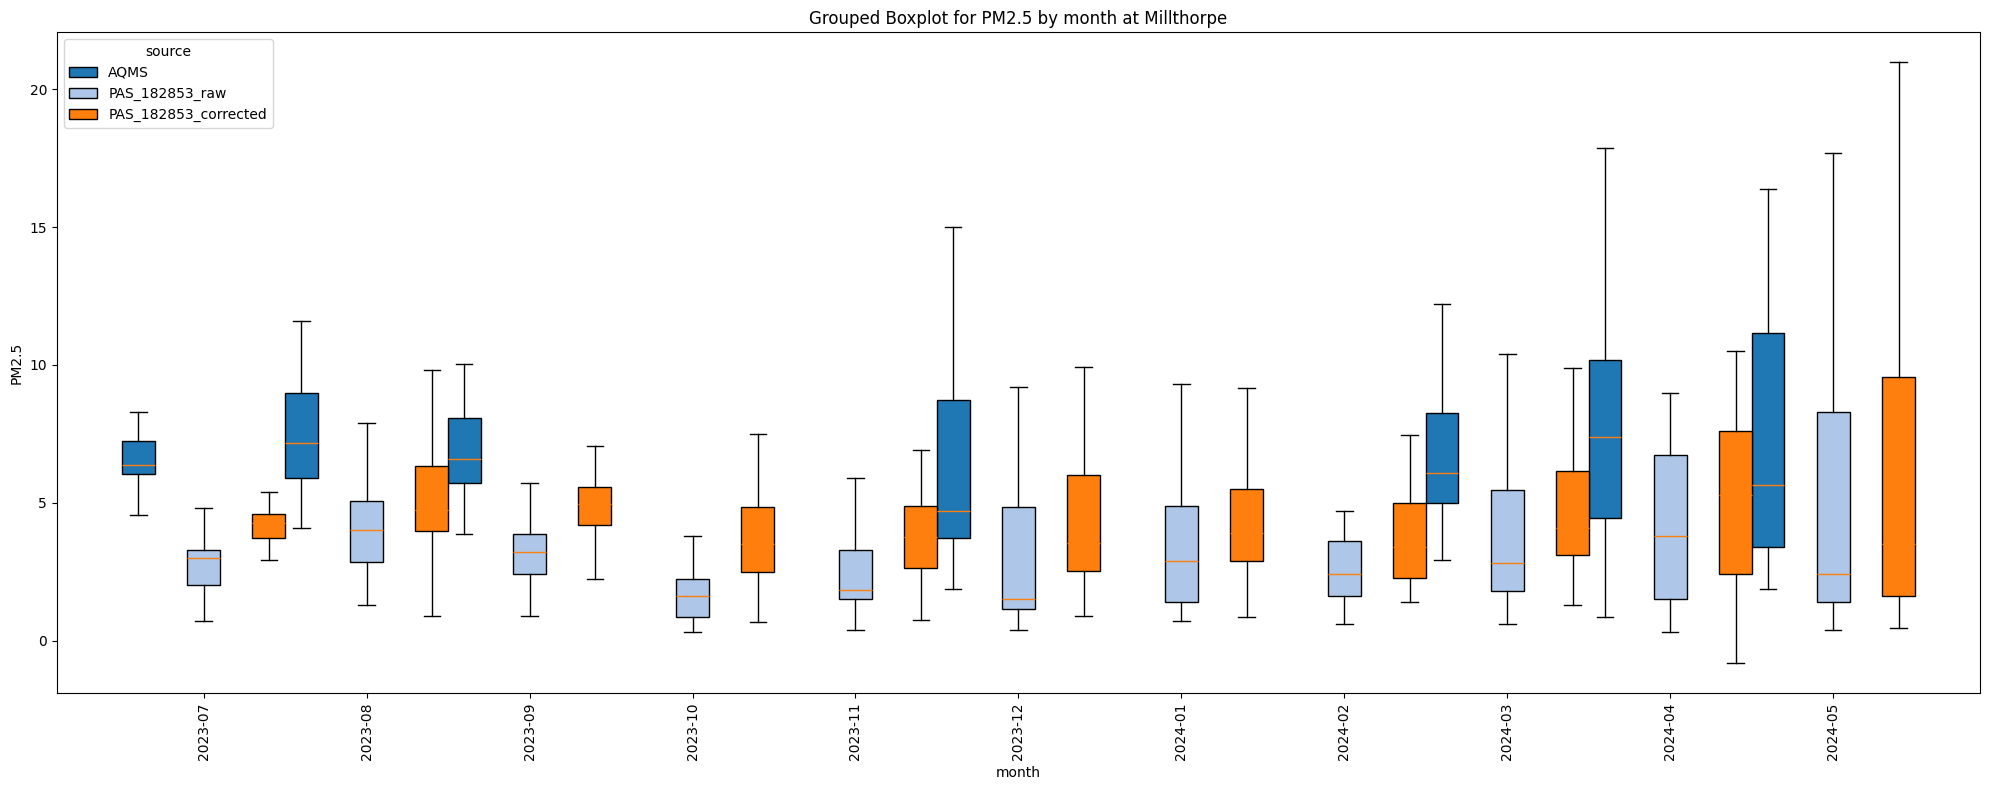

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  PM10      source    month
datetime_utc                                             
2023-07-27 00:00:00+00:00  13.628556        AQMS  2023-07
2023-07-28 00:00:00+00:00  15.305933        AQMS  2023-07
2023-07-29 00:00:00+00:00  11.870444        AQMS  2023-07
2023-07-30 00:00:00+00:00  14.202458        AQMS  2023-07
2023-07-31 00:00:00+00:00  11.114875        AQMS  2023-07
...                              ...         ...      ...
2024-05-25 00:00:00+00:00  14.386000  PAS_182853  2024-05
2024-05-26 00:00:00+00:00  16.532000  PAS_182853  2024-05
2024-05-27 00:00:00+00:00  22.308000  PAS_182853  2024-05
2024-05-28 00:00:00+00:00  16.971000  PAS_182853  2024-05
2024-05-29 00:00:00+00:00  21.810000  PAS_182853  2024-05

[617 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


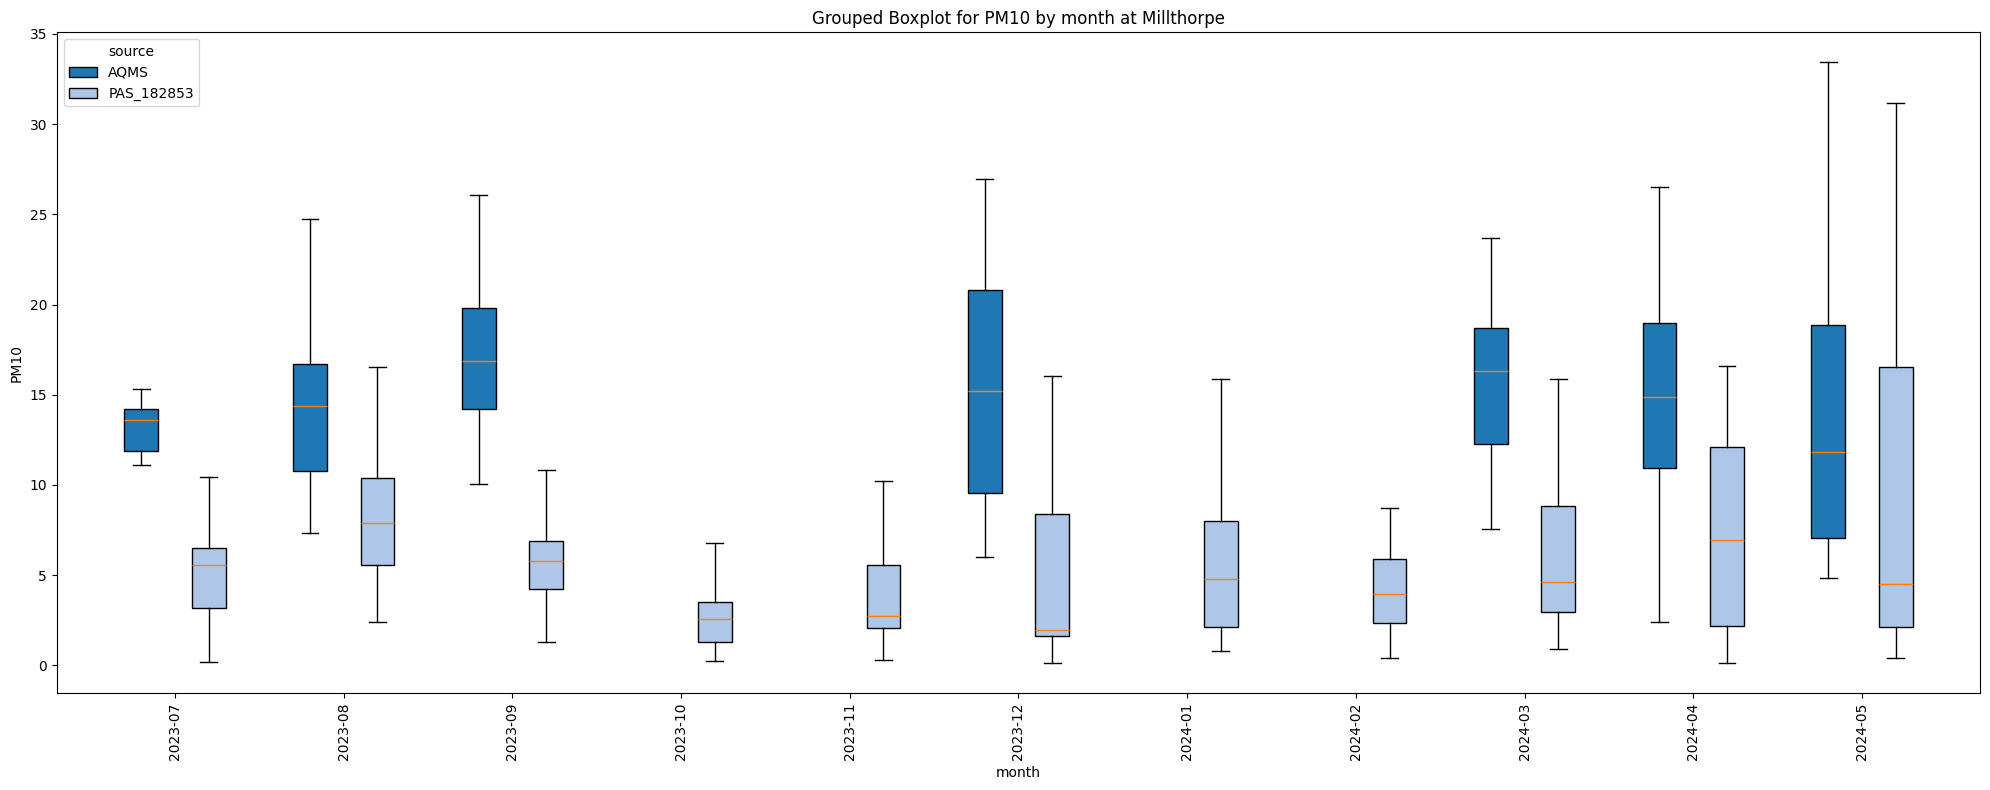

Site:  Wagga_Wagga_North
DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


boxplot data:                                 HUMID     source    month
datetime_utc                                            
2019-04-02 00:00:00+00:00  72.303947       AQMS  2019-04
2019-04-03 00:00:00+00:00  49.175083       AQMS  2019-04
2019-04-04 00:00:00+00:00  58.045176       AQMS  2019-04
2019-04-05 00:00:00+00:00        NaN       AQMS  2019-04
2019-04-06 00:00:00+00:00        NaN       AQMS  2019-04
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  64.404000  PAS_30007  2024-05
2024-05-26 00:00:00+00:00  63.099000  PAS_30007  2024-05
2024-05-27 00:00:00+00:00  62.322000  PAS_30007  2024-05
2024-05-28 00:00:00+00:00  58.893000  PAS_30007  2024-05
2024-05-29 00:00:00+00:00  50.738000  PAS_30007  2024-05

[6988 rows x 3 columns]


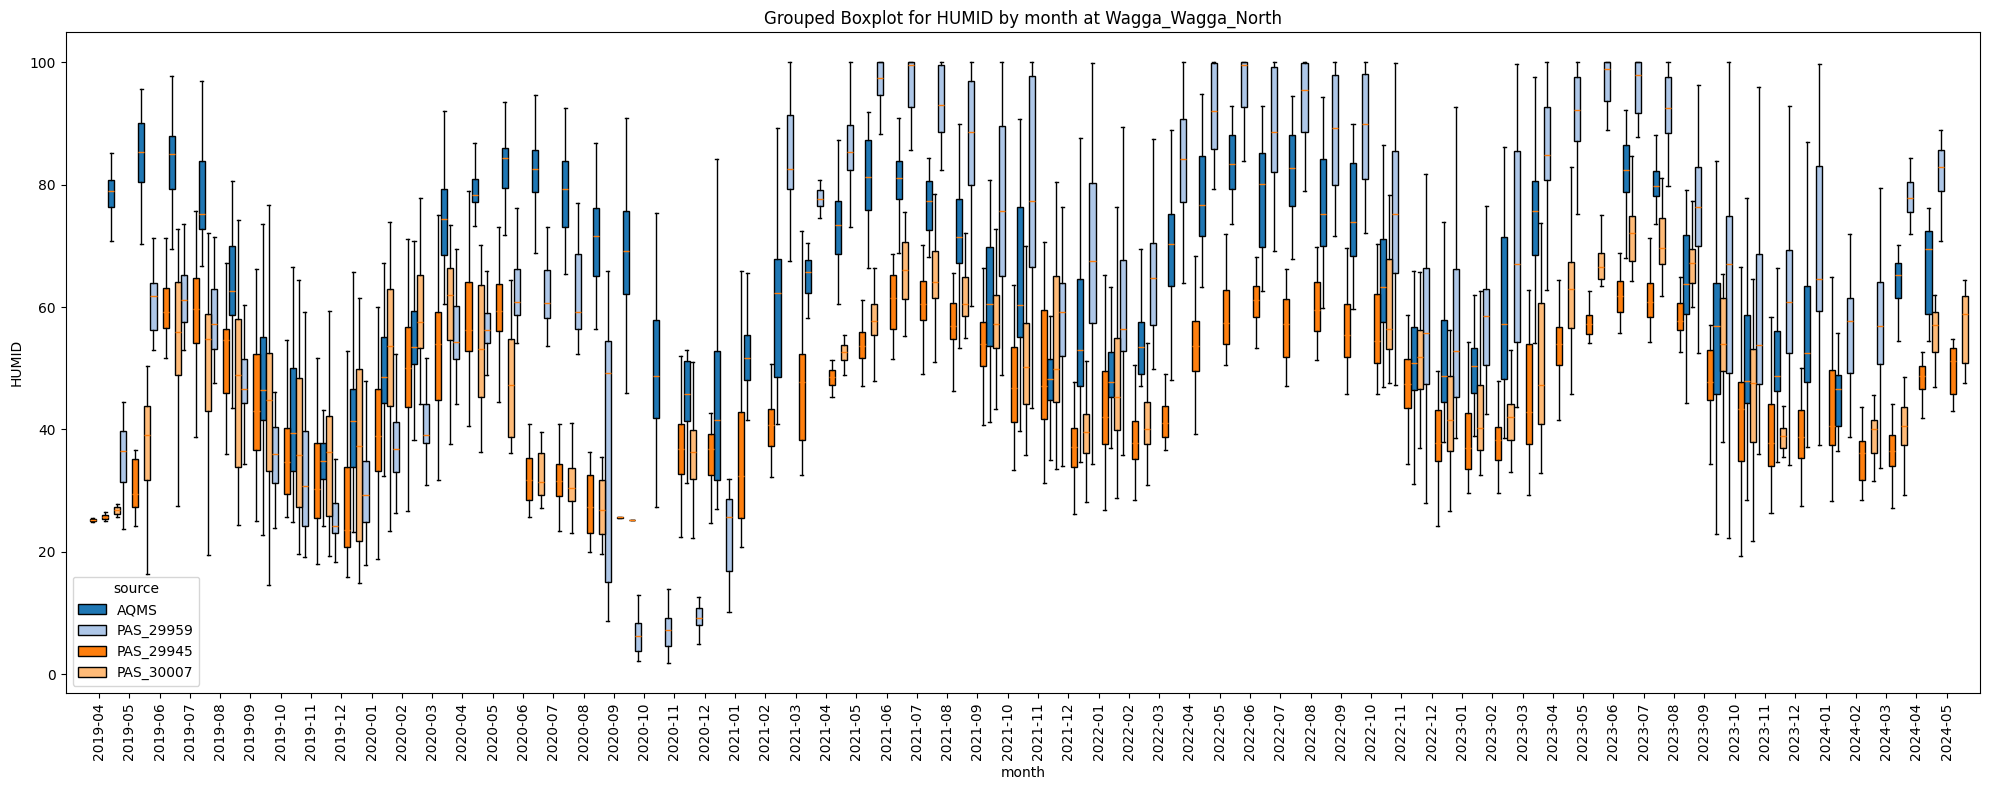

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  TEMP     source    month
datetime_utc                                            
2019-04-02 00:00:00+00:00  17.667105       AQMS  2019-04
2019-04-03 00:00:00+00:00  22.667083       AQMS  2019-04
2019-04-04 00:00:00+00:00  22.136059       AQMS  2019-04
2019-04-05 00:00:00+00:00        NaN       AQMS  2019-04
2019-04-06 00:00:00+00:00        NaN       AQMS  2019-04
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  12.900000  PAS_30007  2024-05
2024-05-26 00:00:00+00:00  12.100000  PAS_30007  2024-05
2024-05-27 00:00:00+00:00  11.000000  PAS_30007  2024-05
2024-05-28 00:00:00+00:00  12.100000  PAS_30007  2024-05
2024-05-29 00:00:00+00:00  19.100000  PAS_30007  2024-05

[6988 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


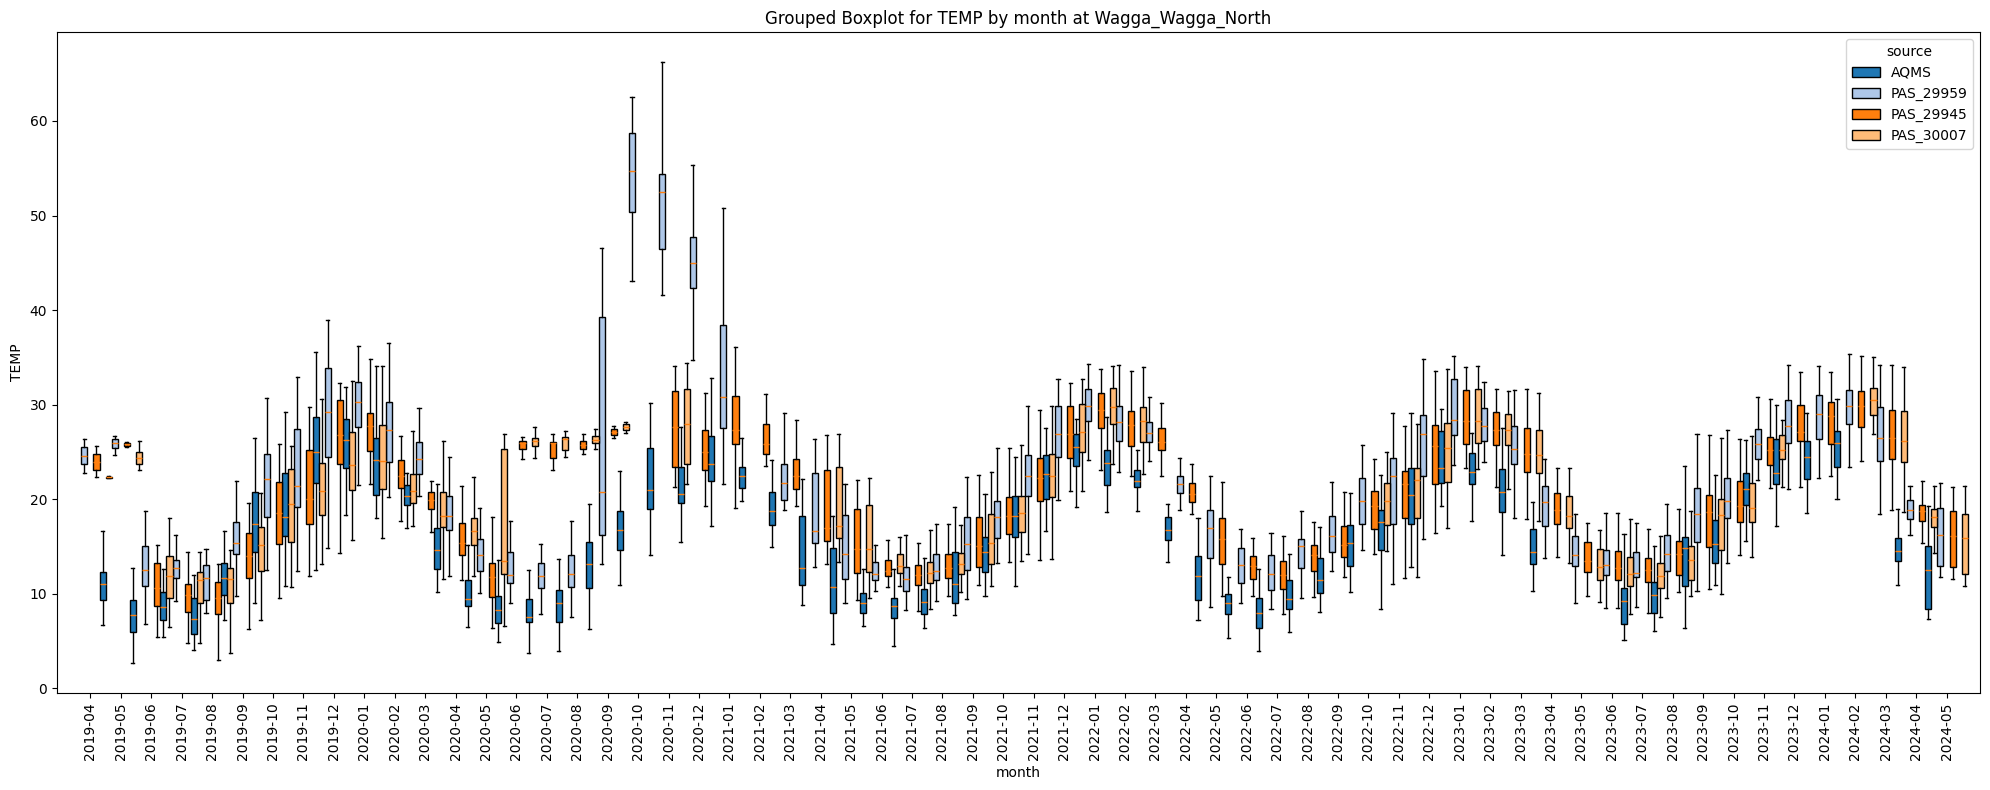

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
COL PAS LIST PAram1:  pm2.5_alt
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_alt
COL PAS LIST PAram1:  pm2.5_corrected
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_corrected
COL PAS LIST PAram1:  pm2.5_alt
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_alt
COL PAS LIST PAram1:  pm2.5_corrected
pas_df.columns:  Index(['timestamp', 'sensor_index', 'humidity', 'temperature', 'pm2.5_alt',
       'pm10.0_atm', 'pm2.5_corrected'],
      dtype='object')
COL PAS LIST PAram2:  pm2.5_corrected
COL PAS LIST PAram1:  pm2.5_al

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


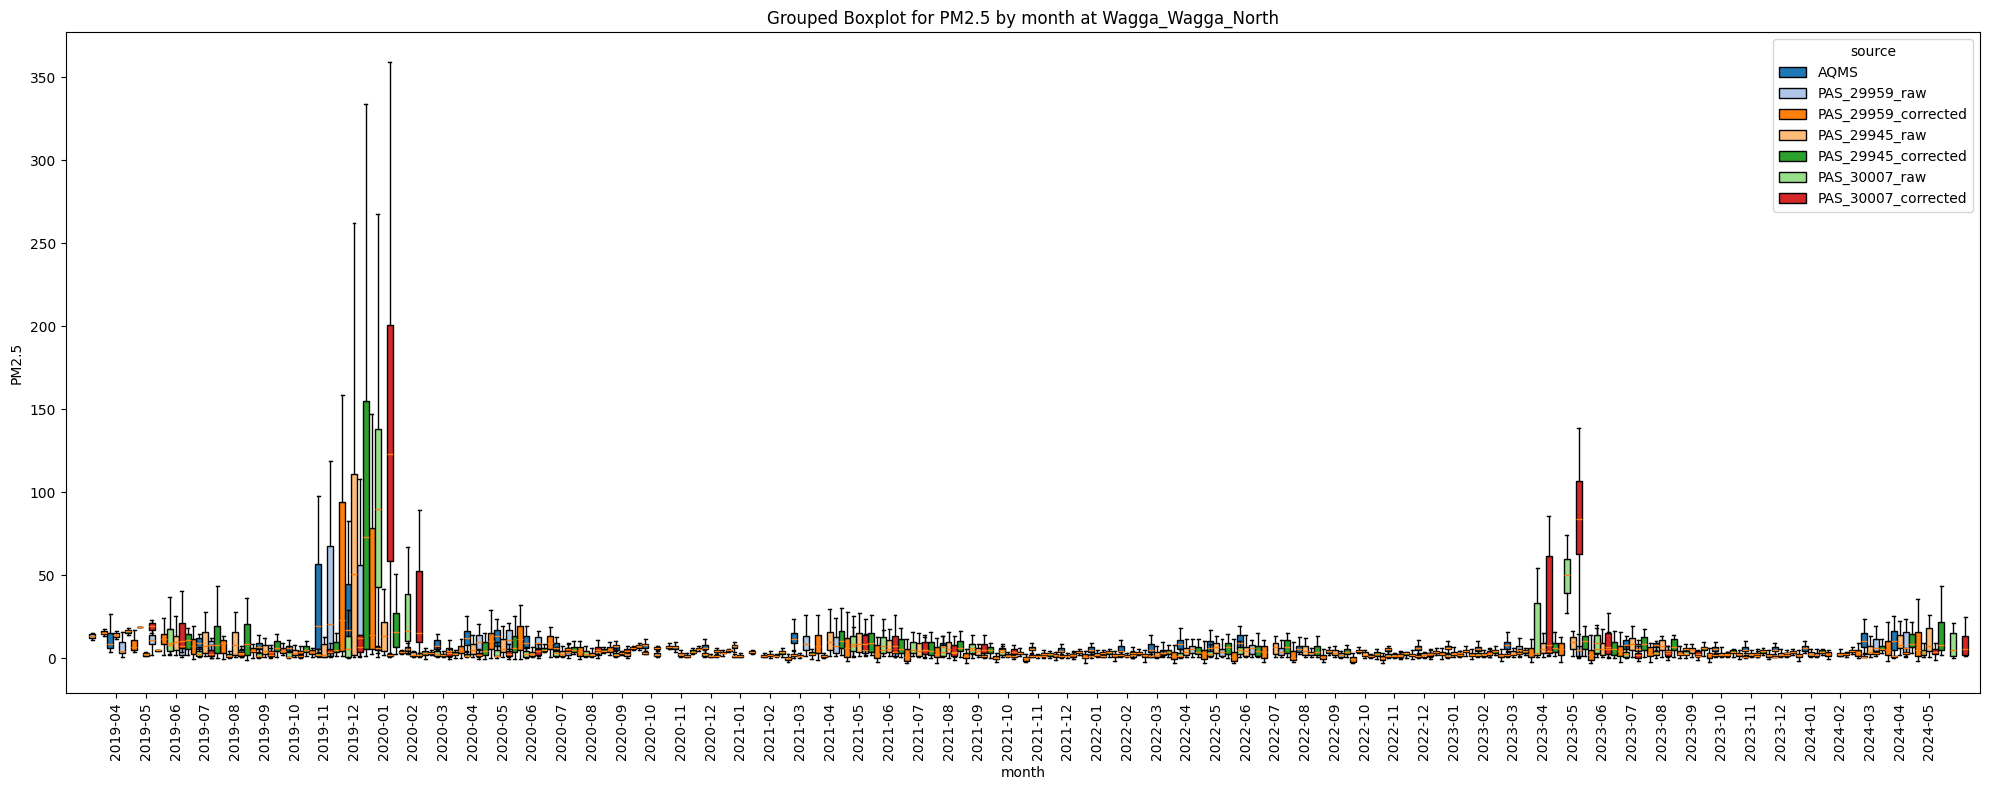

DESCRIPTION: {'pm2.5_alt': 'raw', 'pm2.5_corrected': 'corrected'}
boxplot data:                                  PM10     source    month
datetime_utc                                            
2019-04-02 00:00:00+00:00  23.933263       AQMS  2019-04
2019-04-03 00:00:00+00:00  23.962667       AQMS  2019-04
2019-04-04 00:00:00+00:00  17.757824       AQMS  2019-04
2019-04-05 00:00:00+00:00        NaN       AQMS  2019-04
2019-04-06 00:00:00+00:00        NaN       AQMS  2019-04
...                              ...        ...      ...
2024-05-25 00:00:00+00:00  33.592000  PAS_30007  2024-05
2024-05-26 00:00:00+00:00  31.102000  PAS_30007  2024-05
2024-05-27 00:00:00+00:00  36.656000  PAS_30007  2024-05
2024-05-28 00:00:00+00:00  39.238000  PAS_30007  2024-05
2024-05-29 00:00:00+00:00  14.924000  PAS_30007  2024-05

[6988 rows x 3 columns]


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_16204\2643915264.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  combined_data["month"] = combined_data.index.to_period("M")


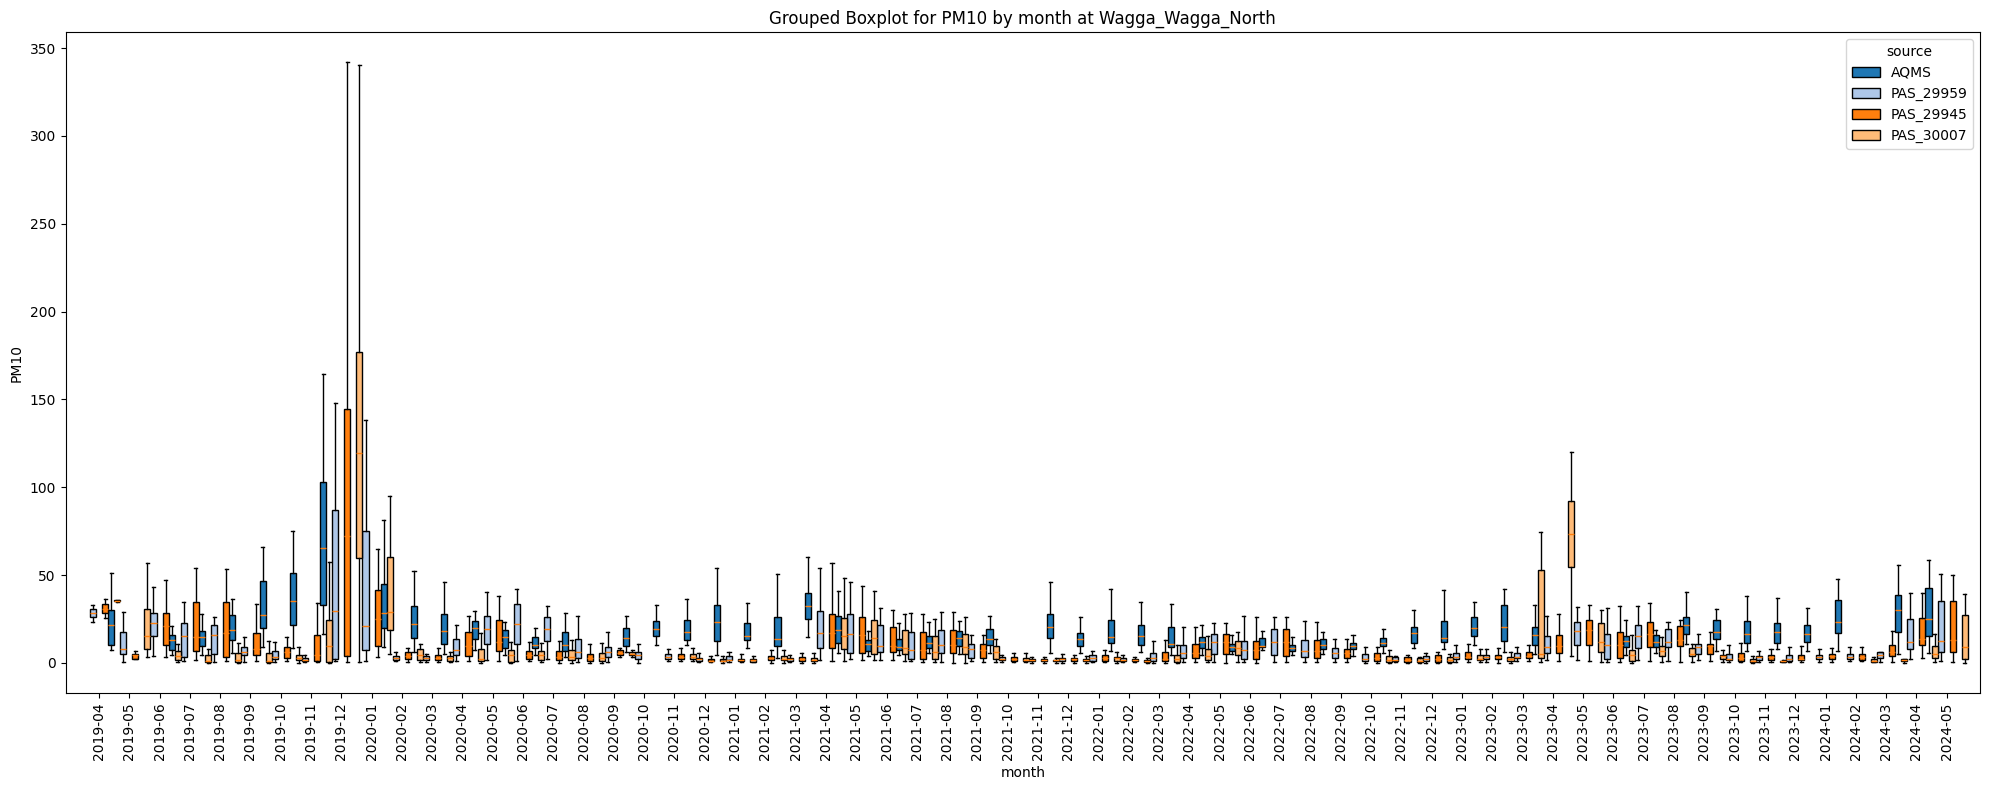

In [14]:

def load_and_prepare_all_sites(metadata_file, descriptions, freq):
    metadata = load_colocation_data(metadata_file)

    for location, details in metadata.items():
        aqms_details = details.get("AQMS", {})
        site_id = details["AQMS"]["site_id"]
        aqms_start_date, aqms_end_date = aqms_details["data_range"]

        sensors = details.get("PAS", {})
        pas_filepaths = {}
        for sensor_id, sensor_details in sensors.items():
            sensor_start_date, sensor_end_date = sensor_details["data_range"]

            start_date = max(aqms_start_date, sensor_start_date)
            end_date = min(aqms_end_date, sensor_end_date)

            start_date_formatted = start_date.replace("-", "")
            end_date_formatted = end_date.replace("-", "")
            aqms_filepath = f"../../../data/raw/colocation/{location}/AQMS/{start_date_formatted}_{end_date_formatted}/aqms_{site_id}_{start_date_formatted}_{end_date_formatted}_{freq}.csv"
            pas_filepath = f"../../../data/processed/colocation/{location}/PAS/{sensor_id}/{start_date_formatted}_{end_date_formatted}/pas_{sensor_id}_{start_date_formatted}_{end_date_formatted}_{freq}.csv"
            pas_filepaths[sensor_id] = pas_filepath

        aqms_data, pas_data = load_site_data(
            aqms_filepath,
            pas_filepaths,
        )
        print("Site: ", location)
        parameters = list(HEADER_MAPPING.keys())

        for parameter in parameters:
            print("DESCRIPTION:", descriptions)
            boxplot_data = prepare_boxplot_data(
                aqms_data, pas_data, parameter, HEADER_MAPPING, descriptions
            )
            print("boxplot data: ", boxplot_data)
            folderpathdir = os.path.join(
                "fig",
                "climatology",
                "colocation",
                location,
                # "PAS",
                # sensor_id,
                f"{start_date_formatted}_{end_date_formatted}",
                parameter,
            )
            if not os.path.exists(folderpathdir):
                os.makedirs(folderpathdir)

            filename = os.path.join(
                folderpathdir,
                f"{location}_{parameter}_{start_date_formatted}_{end_date_formatted}_{freq}.png",
            )
            plot_grouped_boxplots(
                boxplot_data,
                value_col=parameter,
                group_col="source",
                x_col="month",
                site=location,
                savefig_dir=filename
            )


descriptions = {"pm2.5_alt": "raw", "pm2.5_corrected": "corrected"}


# Load and prepare data for all sites
metadata_file = "../../../metadata/colocation/colocation.json"
load_and_prepare_all_sites(metadata_file, descriptions, "daily")
# print(all_sites_data)